# Analisis Performa Algoritma Gradient Boost untuk Menentukan Features dan Parameter yang Paling Optimal dalam Memprediksi Pergerakan Harga Saham

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Menyiapkan Data

#### Load dataset

In [33]:
amazon = pd.read_csv('./AMZN.csv')

In [34]:
amazon.head()

Date       Low      Open      Volume      High     Close  \
0  15-05-1997  0.096354  0.121875  1443120000  0.125000  0.097917   
1  16-05-1997  0.085417  0.098438   294000000  0.098958  0.086458   
2  19-05-1997  0.081250  0.088021   122136000  0.088542  0.085417   
3  20-05-1997  0.081771  0.086458   109344000  0.087500  0.081771   
4  21-05-1997  0.068750  0.081771   377064000  0.082292  0.071354   

   Adjusted Close  
0        0.097917  
1        0.086458  
2        0.085417  
3        0.081771  
4        0.071354

In [35]:
amazon.tail()

Date         Low        Open    Volume        High       Close  \
6399  18-10-2022  114.790001  119.059998  65607400  119.519997  116.360001   
6400  19-10-2022  113.220001  114.709999  47198100  116.589996  115.070000   
6401  20-10-2022  113.510002  113.830002  48795100  118.239998  115.250000   
6402  21-10-2022  114.500000  114.790001  55611900  119.589996  119.320000   
6403  24-10-2022  116.574997  119.980003  23475015  120.389999  119.089996   

      Adjusted Close  
6399      116.360001  
6400      115.070000  
6401      115.250000  
6402      119.320000  
6403      119.089996

In [36]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6404 entries, 0 to 6403
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            6404 non-null   object 
 1   Low             6404 non-null   float64
 2   Open            6404 non-null   float64
 3   Volume          6404 non-null   int64  
 4   High            6404 non-null   float64
 5   Close           6404 non-null   float64
 6   Adjusted Close  6404 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 350.3+ KB


#### Merubah tipe data kolom `Date` menjadi `datetime` dengan format YYYY/MM/DD

In [37]:
amazon['Date'] = pd.to_datetime(amazon['Date'], format='%d-%m-%Y')

In [38]:
amazon.head()

Date       Low      Open      Volume      High     Close  \
0 1997-05-15  0.096354  0.121875  1443120000  0.125000  0.097917   
1 1997-05-16  0.085417  0.098438   294000000  0.098958  0.086458   
2 1997-05-19  0.081250  0.088021   122136000  0.088542  0.085417   
3 1997-05-20  0.081771  0.086458   109344000  0.087500  0.081771   
4 1997-05-21  0.068750  0.081771   377064000  0.082292  0.071354   

   Adjusted Close  
0        0.097917  
1        0.086458  
2        0.085417  
3        0.081771  
4        0.071354

In [39]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6404 entries, 0 to 6403
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            6404 non-null   datetime64[ns]
 1   Low             6404 non-null   float64       
 2   Open            6404 non-null   float64       
 3   Volume          6404 non-null   int64         
 4   High            6404 non-null   float64       
 5   Close           6404 non-null   float64       
 6   Adjusted Close  6404 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 350.3 KB


## Exploratory Data Analysis (EDA)

#### Melihat tanggal pertama dan terakhir dari dataset

In [40]:
print(f"Tanggal data pertama: {amazon['Date'].min()}")
print(f"Tanggal data terakhir: {amazon['Date'].max()}")

Tanggal data pertama: 1997-05-15 00:00:00
Tanggal data terakhir: 2022-10-24 00:00:00


#### Plot semua kolom terhadap `Date`

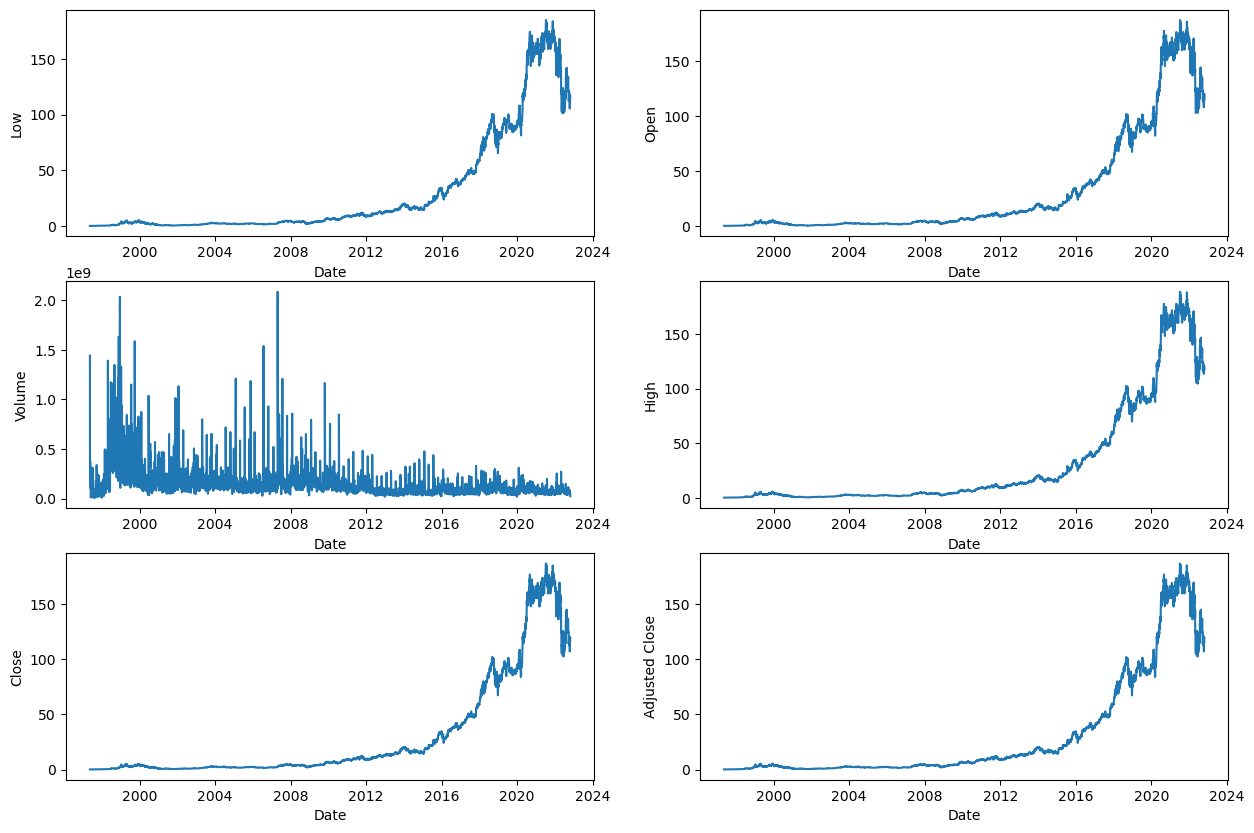

In [41]:
cols = ["Low", "Open", "Volume", "High", "Close", "Adjusted Close"]

fig, axs  = plt.subplots(3, 2, figsize=(15, 10))

for col, ax in zip(cols, axs.flat):
        ax.plot(amazon["Date"], amazon[col])

        ax.set_xlabel("Date")
        ax.set_ylabel(col)

plt.show()

#### Sebaran data setiap kolom

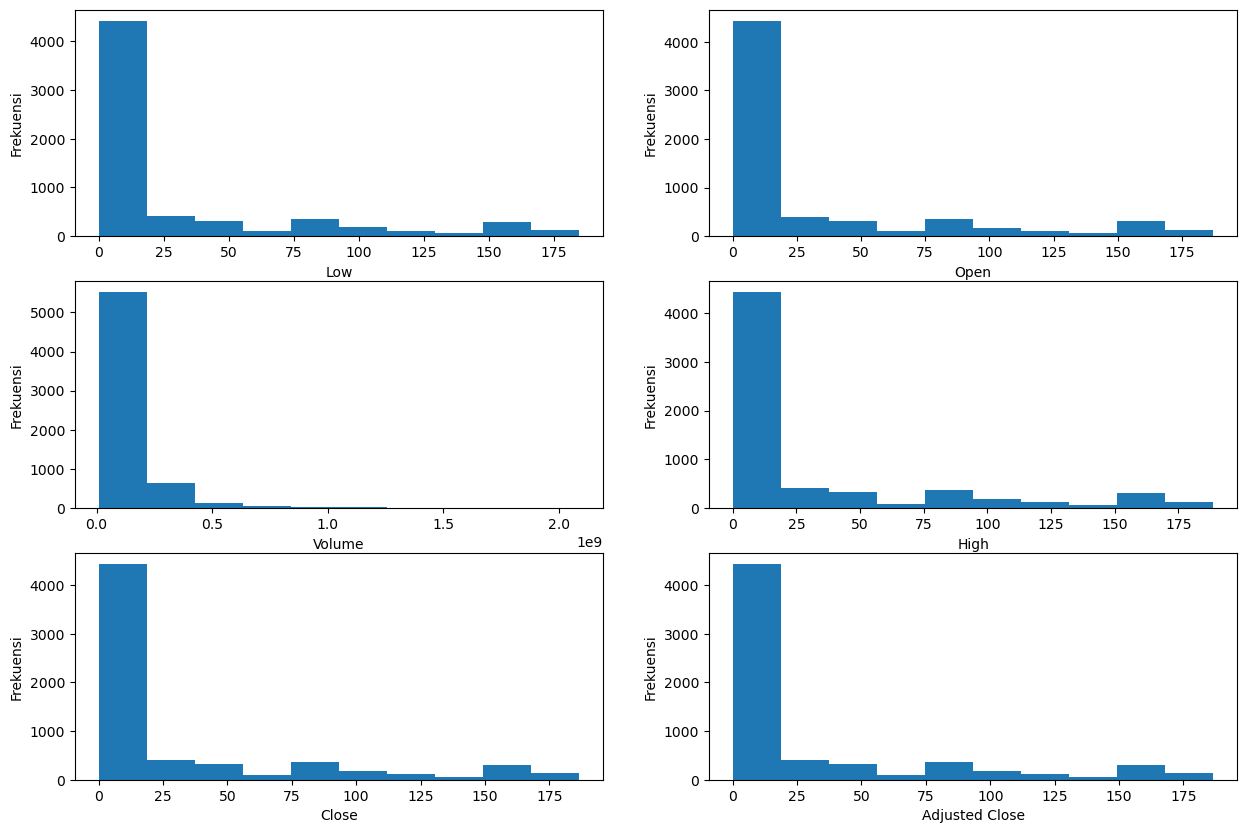

In [42]:
cols = ["Low", "Open", "Volume", "High", "Close", "Adjusted Close"]

fig, axs  = plt.subplots(3, 2, figsize=(15, 10))

for col, ax in zip(cols, axs.flat):
        ax.hist(amazon[col], bins=10)

        ax.set_xlabel(col)
        ax.set_ylabel('Frekuensi')

plt.show()

In [43]:
amazon.describe()

Low         Open        Volume         High        Close  \
count  6404.000000  6404.000000  6.404000e+03  6404.000000  6404.000000   
mean     30.101906    30.497169  1.436908e+08    30.857922    30.486092   
std      47.140467    47.755603  1.410520e+08    48.306722    47.720439   
min       0.065625     0.070313  9.744000e+06     0.072396     0.069792   
25%       1.942875     1.976750  6.945200e+07     2.013625     1.983625   
50%       6.038000     6.152250  1.067220e+08     6.278000     6.161250   
75%      35.625500    35.861501  1.621460e+08    36.110125    35.895750   
max     184.839493   187.199997  2.086584e+09   188.654007   186.570496   

       Adjusted Close  
count     6404.000000  
mean        30.486092  
std         47.720439  
min          0.069792  
25%          1.983625  
50%          6.161250  
75%         35.895750  
max        186.570496

In [44]:
print(f"Low: nilai min = {amazon['Low'].min()}, nilai max = {amazon['Low'].max()}")
print(f"Open: nilai min = {amazon['Open'].min()}, nilai max = {amazon['Open'].max()}")
print(f"Volume: nilai min = {amazon['Volume'].min()}, nilai max = {amazon['Volume'].max()}")
print(f"High: nilai min = {amazon['High'].min()}, nilai max = {amazon['High'].max()}")
print(f"Close: nilai min = {amazon['Close'].min()}, nilai max = {amazon['Close'].max()}")
print(f"Adjusted Close: nilai min = {amazon['Adjusted Close'].min()}, nilai max = {amazon['Adjusted Close'].max()}")

Low: nilai min = 0.0656249970197677, nilai max = 184.8394927978516
Open: nilai min = 0.0703129991889, nilai max = 187.1999969482422
Volume: nilai min = 9744000, nilai max = 2086584000
High: nilai min = 0.0723960027098655, nilai max = 188.6540069580078
Close: nilai min = 0.0697920024394989, nilai max = 186.57049560546875
Adjusted Close: nilai min = 0.0697920024394989, nilai max = 186.57049560546875


## Pre-processing

### Features selection

Menggunakan Pearson Correlation

In [45]:
correlation = amazon.corr()

#### Nilai Pearson Correlation

In [46]:
print(correlation)

                     Low      Open    Volume      High     Close  \
Low             1.000000  0.999899 -0.259082  0.999873  0.999908   
Open            0.999899  1.000000 -0.257848  0.999918  0.999800   
Volume         -0.259082 -0.257848  1.000000 -0.256707 -0.257890   
High            0.999873  0.999918 -0.256707  1.000000  0.999904   
Close           0.999908  0.999800 -0.257890  0.999904  1.000000   
Adjusted Close  0.999908  0.999800 -0.257890  0.999904  1.000000   

                Adjusted Close  
Low                   0.999908  
Open                  0.999800  
Volume               -0.257890  
High                  0.999904  
Close                 1.000000  
Adjusted Close        1.000000  


#### Heatmap Pearson Correlation

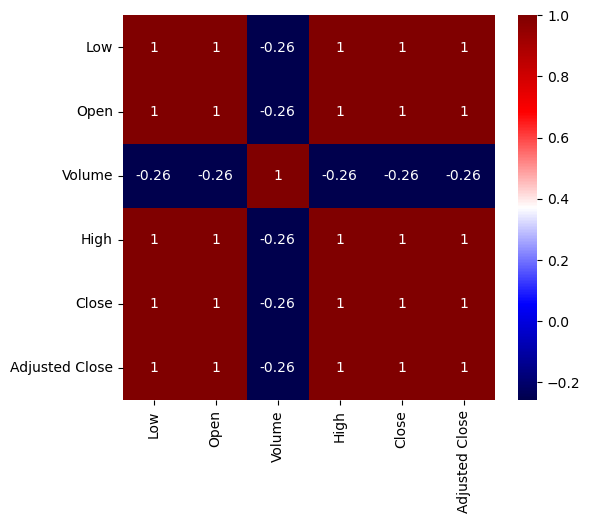

In [47]:
plt.figure(figsize=(6, 5))
sns.heatmap(correlation, cmap='seismic', annot=True)

plt.show()

#### Features yang terpilih

Feature yang terpilih memiliki korelasi lebih dari 0.6 terhadap `Adjusted Close`

In [48]:
corr_target = abs(correlation['Adjusted Close'])

relevant_features = corr_target[corr_target > 0.6]
print(relevant_features)

Low               0.999908
Open              0.999800
High              0.999904
Close             1.000000
Adjusted Close    1.000000
Name: Adjusted Close, dtype: float64


#### Dataframe baru yang berisi features yang relevan

In [49]:
relevant = amazon.copy()
relevant.drop(labels='Volume', axis=1, inplace=True)

relevant.head()

Date       Low      Open      High     Close  Adjusted Close
0 1997-05-15  0.096354  0.121875  0.125000  0.097917        0.097917
1 1997-05-16  0.085417  0.098438  0.098958  0.086458        0.086458
2 1997-05-19  0.081250  0.088021  0.088542  0.085417        0.085417
3 1997-05-20  0.081771  0.086458  0.087500  0.081771        0.081771
4 1997-05-21  0.068750  0.081771  0.082292  0.071354        0.071354

### Scaling

melakukan scaling data dengan rentang 0-1

In [50]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled = scaler.fit_transform(relevant.iloc[:, 1:])

#### Dataframe yang nilainya sudah di-scaling

In [51]:
scaled = pd.DataFrame(scaled, columns=['Low', 'Open', 'High', 'Close', 'Adjusted Close'])
scaled.insert(0, 'Date', amazon['Date'], True)
scaled.head()

Date       Low      Open      High     Close  Adjusted Close
0 1997-05-15  0.000166  0.000276  0.000279  0.000151        0.000151
1 1997-05-16  0.000107  0.000150  0.000141  0.000089        0.000089
2 1997-05-19  0.000085  0.000095  0.000086  0.000084        0.000084
3 1997-05-20  0.000087  0.000086  0.000080  0.000064        0.000064
4 1997-05-21  0.000017  0.000061  0.000052  0.000008        0.000008

## Cross Validation

Menggunakan Time Series Split

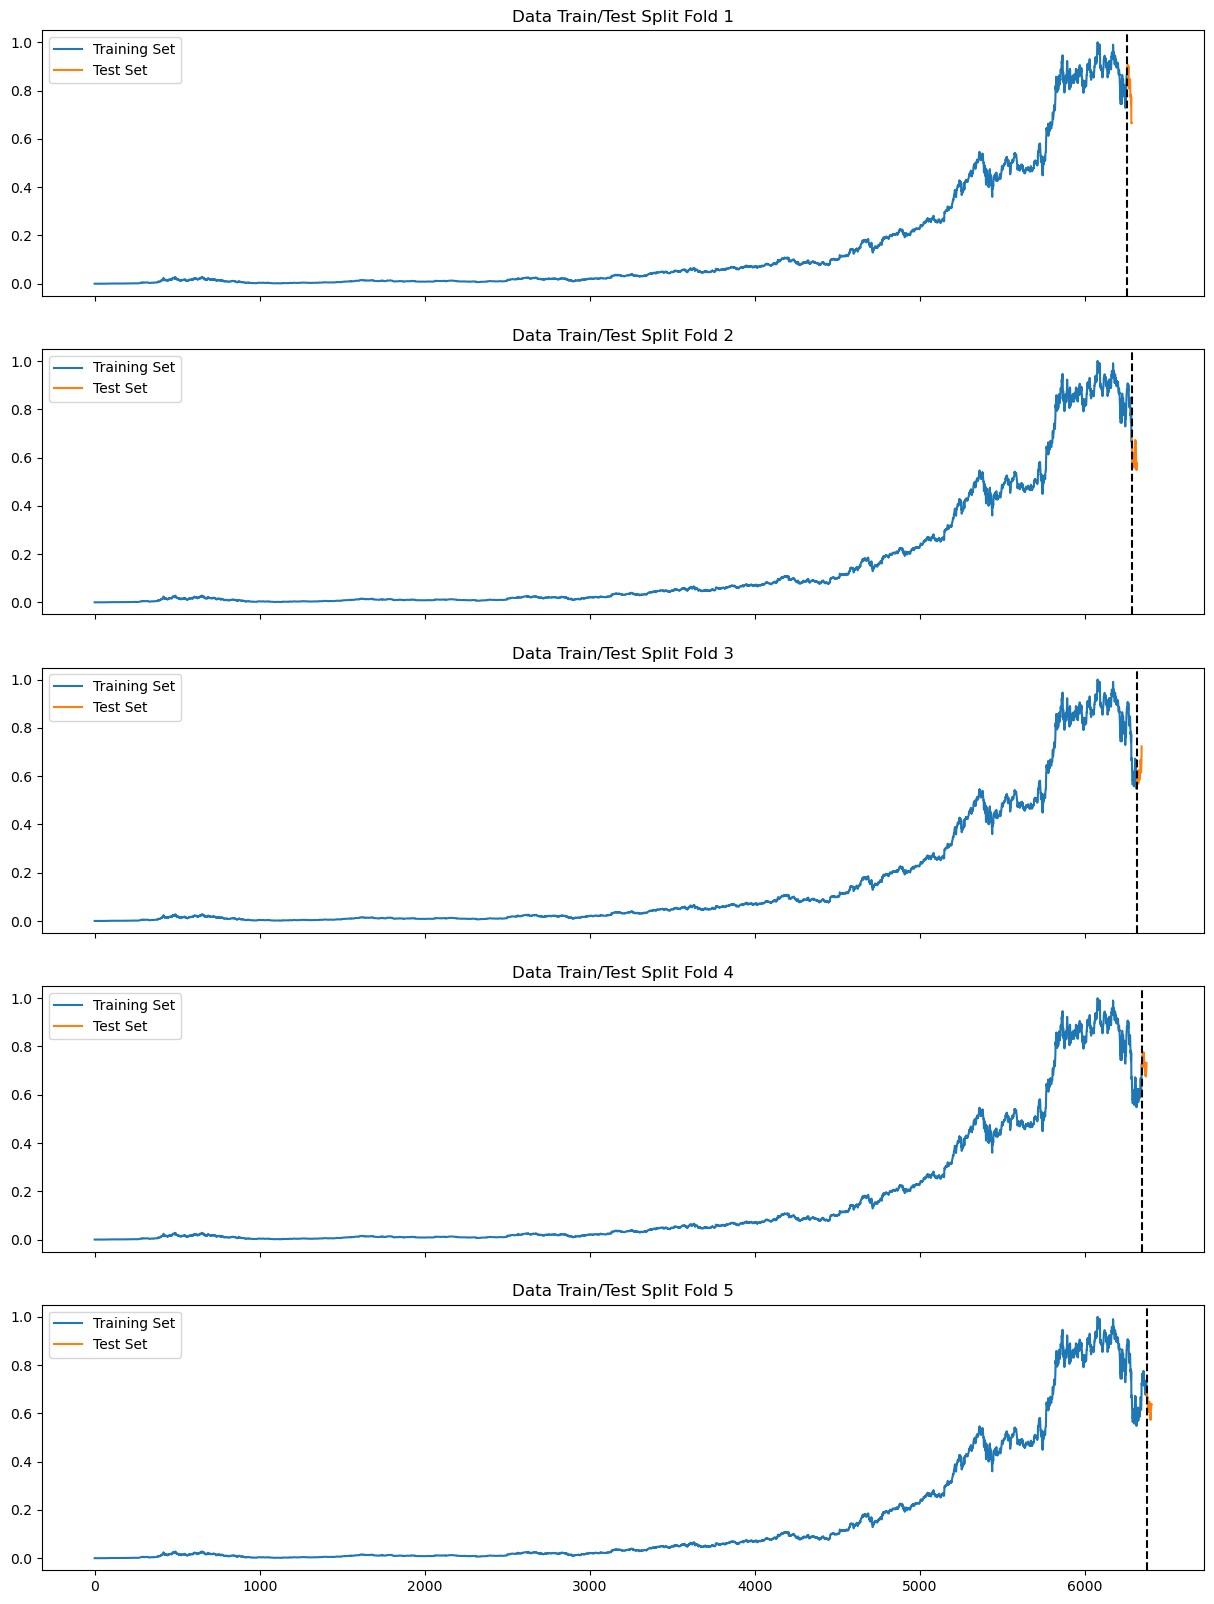

In [52]:
tss = TimeSeriesSplit(n_splits=5, test_size=30)

fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(scaled):
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    train['Adjusted Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold+1}')
    test['Adjusted Close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()
    fold += 1

plt.show()


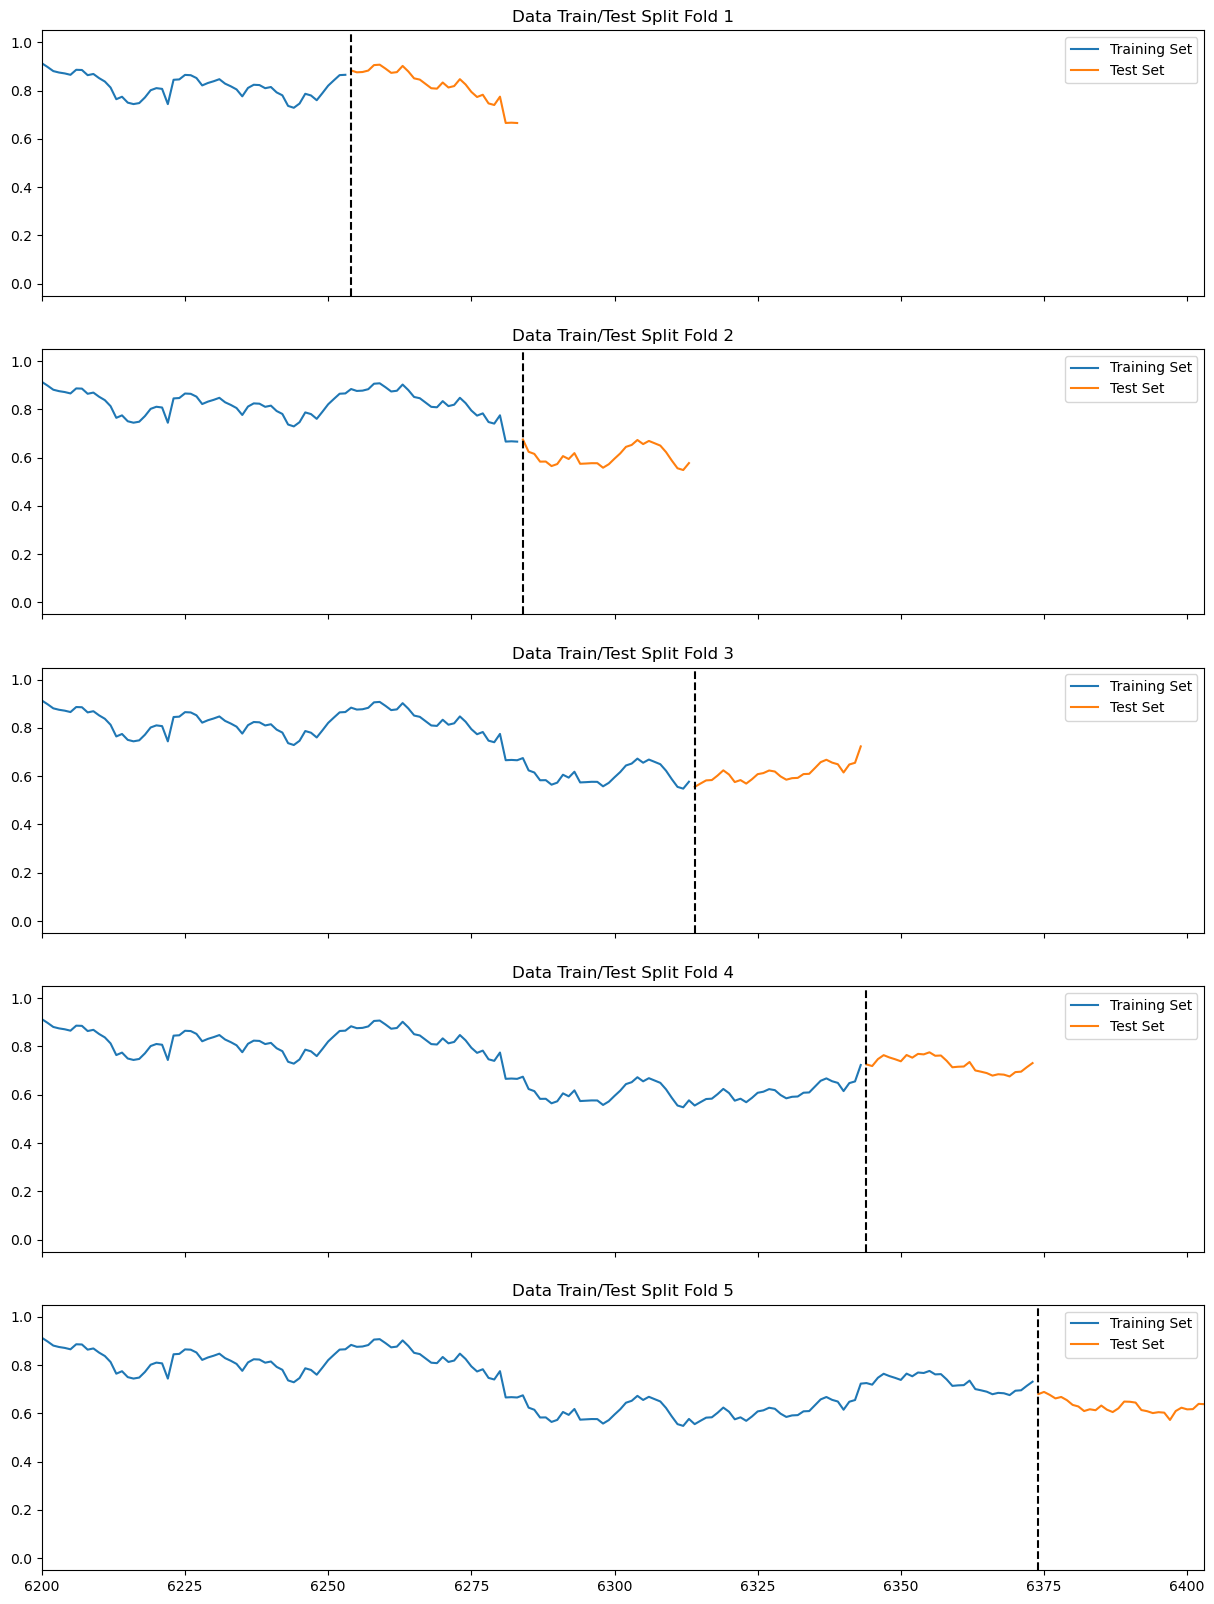

In [53]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(scaled):
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    train['Adjusted Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold+1}')
    test['Adjusted Close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()
    fold += 1

plt.xlim(scaled.index[6200], scaled.index[6403])
plt.show()

## Model

Jumlah pohon = 500

Early stopping rounds = 3

Learning rate = 0.01, 0.05, 0.1

kedalaman pohon = 3, 4, 5

Model = 1 x 3 x 3 = 9

### Model 1
### Learning rate=0.01, kedalaman pohon=3

In [54]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.01, 'max_depth': 3}

pred_lr001_kp3 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr001_kp3 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr001_kp3.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr001_kp3['date_fold_' + str(fold)] = test_date.values
    pred_lr001_kp3['real_fold_' + str(fold)] = y_test.values
    pred_lr001_kp3['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.42268	validation_1-rmse:0.32562
[50]	validation_0-rmse:0.25624	validation_1-rmse:0.19440
[100]	validation_0-rmse:0.15539	validation_1-rmse:0.11666
[150]	validation_0-rmse:0.09428	validation_1-rmse:0.06985
[200]	validation_0-rmse:0.05724	validation_1-rmse:0.04165
[250]	validation_0-rmse:0.03477	validation_1-rmse:0.02493
[300]	validation_0-rmse:0.02114	validation_1-rmse:0.01508
[350]	validation_0-rmse:0.01287	validation_1-rmse:0.00919
[400]	validation_0-rmse:0.00784	validation_1-rmse:0.00559
[450]	validation_0-rmse:0.00479	validation_1-rmse:0.00344
[499]	validation_0-rmse:0.00296	validation_1-rmse:0.00218


Train pada Fold-2
[0]	validation_0-rmse:0.42227	validation_1-rmse:0.11192
[50]	validation_0-rmse:0.25600	validation_1-rmse:0.07583
[100]	validation_0-rmse:0.15526	validation_1-rmse:0.04873
[150]	validation_0-rmse:0.09420	validation_1-rmse:0.03209
[200]	validation_0-rmse:0.05719	validation_1-rmse:0.02143
[250]	validation_0-rmse:0.03475	validati

In [55]:
pred_lr001_kp3 = pred_lr001_kp3.reset_index(drop=True)
pred_lr001_kp3.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.881186  2022-05-04     0.674843     0.665464   
1  2022-03-23     0.875805     0.873675  2022-05-05     0.623790     0.622999   
2  2022-03-24     0.877100     0.874788  2022-05-06     0.615026     0.611033   
3  2022-03-25     0.883126     0.880490  2022-05-09     0.582943     0.580354   
4  2022-03-28     0.905738     0.902587  2022-05-10     0.583318     0.579961   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.548277  2022-08-01     0.725575     0.725933   
1  2022-06-17     0.569168     0.570888  2022-08-02     0.718980     0.717346   
2  2022-06-21     0.582358     0.581855  2022-08-03     0.747719     0.747195   
3  2022-06-22     0.583806     0.582273  2022-08-04     0.764073     0.763016   
4  2022-06-23     0.602519     0.604699  2022-08-05     0.754583     0.748908   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.678091  
1  2022-09-14     0.688899     0.688161  
2  2022-09-15     0.676728     0.674805  
3  2022-09-16     0.661983     0.660762  
4  2022-09-19     0.668042     0.666349

### Model 2
### Learning rate=0.01, kedalaman pohon=4

In [56]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.01, 'max_depth': 4}

pred_lr001_kp4 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr001_kp4 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr001_kp4.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr001_kp4['date_fold_' + str(fold)] = test_date.values
    pred_lr001_kp4['real_fold_' + str(fold)] = y_test.values
    pred_lr001_kp4['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.42268	validation_1-rmse:0.32567
[50]	validation_0-rmse:0.25601	validation_1-rmse:0.19657
[100]	validation_0-rmse:0.15508	validation_1-rmse:0.11904
[150]	validation_0-rmse:0.09395	validation_1-rmse:0.07208
[200]	validation_0-rmse:0.05692	validation_1-rmse:0.04368
[250]	validation_0-rmse:0.03449	validation_1-rmse:0.02644
[300]	validation_0-rmse:0.02090	validation_1-rmse:0.01601
[350]	validation_0-rmse:0.01267	validation_1-rmse:0.00975
[400]	validation_0-rmse:0.00768	validation_1-rmse:0.00593
[450]	validation_0-rmse:0.00466	validation_1-rmse:0.00366
[499]	validation_0-rmse:0.00285	validation_1-rmse:0.00235


Train pada Fold-2
[0]	validation_0-rmse:0.42227	validation_1-rmse:0.11115
[50]	validation_0-rmse:0.25577	validation_1-rmse:0.06868
[100]	validation_0-rmse:0.15493	validation_1-rmse:0.04275
[150]	validation_0-rmse:0.09386	validation_1-rmse:0.02751
[200]	validation_0-rmse:0.05686	validation_1-rmse:0.01838
[250]	validation_0-rmse:0.03445	validati

In [57]:
pred_lr001_kp4 = pred_lr001_kp4.reset_index(drop=True)
pred_lr001_kp4.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.880991  2022-05-04     0.674843     0.666007   
1  2022-03-23     0.875805     0.873382  2022-05-05     0.623790     0.622865   
2  2022-03-24     0.877100     0.874450  2022-05-06     0.615026     0.611606   
3  2022-03-25     0.883126     0.880289  2022-05-09     0.582943     0.580631   
4  2022-03-28     0.905738     0.902954  2022-05-10     0.583318     0.580269   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.548754  2022-08-01     0.725575     0.725869   
1  2022-06-17     0.569168     0.571163  2022-08-02     0.718980     0.716925   
2  2022-06-21     0.582358     0.582155  2022-08-03     0.747719     0.746979   
3  2022-06-22     0.583806     0.582536  2022-08-04     0.764073     0.763072   
4  2022-06-23     0.602519     0.605016  2022-08-05     0.754583     0.748835   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.678107  
1  2022-09-14     0.688899     0.688048  
2  2022-09-15     0.676728     0.675069  
3  2022-09-16     0.661983     0.660900  
4  2022-09-19     0.668042     0.666710

### Model 3
### Learning rate=0.01, kedalaman pohon=5

In [58]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.01, 'max_depth': 5}

pred_lr001_kp5 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr001_kp5 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr001_kp5.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr001_kp5['date_fold_' + str(fold)] = test_date.values
    pred_lr001_kp5['real_fold_' + str(fold)] = y_test.values
    pred_lr001_kp5['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.42268	validation_1-rmse:0.32567
[50]	validation_0-rmse:0.25599	validation_1-rmse:0.19650
[100]	validation_0-rmse:0.15506	validation_1-rmse:0.11896
[150]	validation_0-rmse:0.09393	validation_1-rmse:0.07209
[200]	validation_0-rmse:0.05690	validation_1-rmse:0.04363
[250]	validation_0-rmse:0.03447	validation_1-rmse:0.02644
[300]	validation_0-rmse:0.02089	validation_1-rmse:0.01606
[350]	validation_0-rmse:0.01266	validation_1-rmse:0.00979
[400]	validation_0-rmse:0.00767	validation_1-rmse:0.00602
[450]	validation_0-rmse:0.00465	validation_1-rmse:0.00375
[499]	validation_0-rmse:0.00285	validation_1-rmse:0.00242


Train pada Fold-2
[0]	validation_0-rmse:0.42227	validation_1-rmse:0.11126
[50]	validation_0-rmse:0.25575	validation_1-rmse:0.06913
[100]	validation_0-rmse:0.15491	validation_1-rmse:0.04333
[150]	validation_0-rmse:0.09384	validation_1-rmse:0.02742
[200]	validation_0-rmse:0.05685	validation_1-rmse:0.01806
[250]	validation_0-rmse:0.03444	validati

In [59]:
pred_lr001_kp5 = pred_lr001_kp5.reset_index(drop=True)
pred_lr001_kp5.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.881034  2022-05-04     0.674843     0.665937   
1  2022-03-23     0.875805     0.873396  2022-05-05     0.623790     0.622979   
2  2022-03-24     0.877100     0.874476  2022-05-06     0.615026     0.611801   
3  2022-03-25     0.883126     0.880332  2022-05-09     0.582943     0.580784   
4  2022-03-28     0.905738     0.903015  2022-05-10     0.583318     0.580430   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.548800  2022-08-01     0.725575     0.725728   
1  2022-06-17     0.569168     0.571205  2022-08-02     0.718980     0.716960   
2  2022-06-21     0.582358     0.582304  2022-08-03     0.747719     0.746786   
3  2022-06-22     0.583806     0.582669  2022-08-04     0.764073     0.762888   
4  2022-06-23     0.602519     0.605140  2022-08-05     0.754583     0.748653   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.678095  
1  2022-09-14     0.688899     0.688051  
2  2022-09-15     0.676728     0.675184  
3  2022-09-16     0.661983     0.660857  
4  2022-09-19     0.668042     0.666618

### Model 4
### Learning rate=0.05, kedalaman pohon=3

In [60]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.05, 'max_depth': 3}

pred_lr005_kp3 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr005_kp3 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr005_kp3.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr005_kp3['date_fold_' + str(fold)] = test_date.values
    pred_lr005_kp3['real_fold_' + str(fold)] = y_test.values
    pred_lr005_kp3['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.40567	validation_1-rmse:0.31230
[50]	validation_0-rmse:0.03171	validation_1-rmse:0.02282
[100]	validation_0-rmse:0.00260	validation_1-rmse:0.00248
[150]	validation_0-rmse:0.00060	validation_1-rmse:0.00164
[173]	validation_0-rmse:0.00056	validation_1-rmse:0.00162


Train pada Fold-2
[0]	validation_0-rmse:0.40527	validation_1-rmse:0.11028
[50]	validation_0-rmse:0.03169	validation_1-rmse:0.01386
[100]	validation_0-rmse:0.00260	validation_1-rmse:0.00806
[150]	validation_0-rmse:0.00060	validation_1-rmse:0.00800
[161]	validation_0-rmse:0.00057	validation_1-rmse:0.00801


Train pada Fold-3
[0]	validation_0-rmse:0.40438	validation_1-rmse:0.11333
[50]	validation_0-rmse:0.03163	validation_1-rmse:0.01217
[100]	validation_0-rmse:0.00260	validation_1-rmse:0.00368
[150]	validation_0-rmse:0.00060	validation_1-rmse:0.00343
[168]	validation_0-rmse:0.00056	validation_1-rmse:0.00343


Train pada Fold-4
[0]	validation_0-rmse:0.40349	validation_1-rmse:0.21454
[50]	

In [61]:
pred_lr005_kp3 = pred_lr005_kp3.reset_index(drop=True)
pred_lr005_kp3.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.882583  2022-05-04     0.674843     0.668541   
1  2022-03-23     0.875805     0.877416  2022-05-05     0.623790     0.629709   
2  2022-03-24     0.877100     0.877416  2022-05-06     0.615026     0.610640   
3  2022-03-25     0.883126     0.882591  2022-05-09     0.582943     0.581694   
4  2022-03-28     0.905738     0.905909  2022-05-10     0.583318     0.581694   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.548563  2022-08-01     0.725575     0.727963   
1  2022-06-17     0.569168     0.572410  2022-08-02     0.718980     0.720351   
2  2022-06-21     0.582358     0.581768  2022-08-03     0.747719     0.744994   
3  2022-06-22     0.583806     0.582997  2022-08-04     0.764073     0.764328   
4  2022-06-23     0.602519     0.602516  2022-08-05     0.754583     0.750169   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.683278  
1  2022-09-14     0.688899     0.691414  
2  2022-09-15     0.676728     0.675274  
3  2022-09-16     0.661983     0.659860  
4  2022-09-19     0.668042     0.667107

### Model 5
### Learning rate=0.05, kedalaman pohon=4

In [62]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.05, 'max_depth': 4}

pred_lr005_kp4 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr005_kp4 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr005_kp4.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr005_kp4['date_fold_' + str(fold)] = test_date.values
    pred_lr005_kp4['real_fold_' + str(fold)] = y_test.values
    pred_lr005_kp4['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.40564	validation_1-rmse:0.31258
[50]	validation_0-rmse:0.03143	validation_1-rmse:0.02406
[100]	validation_0-rmse:0.00246	validation_1-rmse:0.00215
[150]	validation_0-rmse:0.00032	validation_1-rmse:0.00084
[197]	validation_0-rmse:0.00026	validation_1-rmse:0.00079


Train pada Fold-2
[0]	validation_0-rmse:0.40524	validation_1-rmse:0.10643
[50]	validation_0-rmse:0.03140	validation_1-rmse:0.01206
[100]	validation_0-rmse:0.00246	validation_1-rmse:0.00803
[119]	validation_0-rmse:0.00097	validation_1-rmse:0.00801


Train pada Fold-3
[0]	validation_0-rmse:0.40435	validation_1-rmse:0.11284
[50]	validation_0-rmse:0.03133	validation_1-rmse:0.00966
[100]	validation_0-rmse:0.00245	validation_1-rmse:0.00273
[126]	validation_0-rmse:0.00071	validation_1-rmse:0.00269


Train pada Fold-4
[0]	validation_0-rmse:0.40347	validation_1-rmse:0.21825
[50]	validation_0-rmse:0.03127	validation_1-rmse:0.01636
[100]	validation_0-rmse:0.00245	validation_1-rmse:0.00438
[113]	

In [63]:
pred_lr005_kp4 = pred_lr005_kp4.reset_index(drop=True)
pred_lr005_kp4.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.883579  2022-05-04     0.674843     0.665649   
1  2022-03-23     0.875805     0.875731  2022-05-05     0.623790     0.623816   
2  2022-03-24     0.877100     0.876880  2022-05-06     0.615026     0.612175   
3  2022-03-25     0.883126     0.882714  2022-05-09     0.582943     0.582688   
4  2022-03-28     0.905738     0.906148  2022-05-10     0.583318     0.582688   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.551073  2022-08-01     0.725575     0.726290   
1  2022-06-17     0.569168     0.571522  2022-08-02     0.718980     0.718598   
2  2022-06-21     0.582358     0.582312  2022-08-03     0.747719     0.746616   
3  2022-06-22     0.583806     0.582650  2022-08-04     0.764073     0.763654   
4  2022-06-23     0.602519     0.605626  2022-08-05     0.754583     0.750405   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.679080  
1  2022-09-14     0.688899     0.689031  
2  2022-09-15     0.676728     0.675276  
3  2022-09-16     0.661983     0.661728  
4  2022-09-19     0.668042     0.667899

### Model 6
### Learning rate=0.05, kedalaman pohon=5

In [64]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.05, 'max_depth': 5}

pred_lr005_kp5 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr005_kp5 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr005_kp5.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr005_kp5['date_fold_' + str(fold)] = test_date.values
    pred_lr005_kp5['real_fold_' + str(fold)] = y_test.values
    pred_lr005_kp5['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.40563	validation_1-rmse:0.31255
[50]	validation_0-rmse:0.03142	validation_1-rmse:0.02417
[100]	validation_0-rmse:0.00245	validation_1-rmse:0.00230
[150]	validation_0-rmse:0.00030	validation_1-rmse:0.00099
[194]	validation_0-rmse:0.00022	validation_1-rmse:0.00094


Train pada Fold-2
[0]	validation_0-rmse:0.40524	validation_1-rmse:0.10700
[50]	validation_0-rmse:0.03138	validation_1-rmse:0.01234
[100]	validation_0-rmse:0.00245	validation_1-rmse:0.00835
[150]	validation_0-rmse:0.00030	validation_1-rmse:0.00830
[164]	validation_0-rmse:0.00025	validation_1-rmse:0.00830


Train pada Fold-3
[0]	validation_0-rmse:0.40434	validation_1-rmse:0.11261
[50]	validation_0-rmse:0.03132	validation_1-rmse:0.00920
[100]	validation_0-rmse:0.00245	validation_1-rmse:0.00262
[122]	validation_0-rmse:0.00083	validation_1-rmse:0.00256


Train pada Fold-4
[0]	validation_0-rmse:0.40346	validation_1-rmse:0.21823
[50]	validation_0-rmse:0.03125	validation_1-rmse:0.01649
[100]	

In [65]:
pred_lr005_kp5 = pred_lr005_kp5.reset_index(drop=True)
pred_lr005_kp5.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.883777  2022-05-04     0.674843     0.665935   
1  2022-03-23     0.875805     0.876254  2022-05-05     0.623790     0.624802   
2  2022-03-24     0.877100     0.876177  2022-05-06     0.615026     0.612461   
3  2022-03-25     0.883126     0.882845  2022-05-09     0.582943     0.581315   
4  2022-03-28     0.905738     0.906197  2022-05-10     0.583318     0.581091   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.549868  2022-08-01     0.725575     0.726997   
1  2022-06-17     0.569168     0.571517  2022-08-02     0.718980     0.720101   
2  2022-06-21     0.582358     0.582608  2022-08-03     0.747719     0.747750   
3  2022-06-22     0.583806     0.583098  2022-08-04     0.764073     0.763125   
4  2022-06-23     0.602519     0.605590  2022-08-05     0.754583     0.750016   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.679376  
1  2022-09-14     0.688899     0.688819  
2  2022-09-15     0.676728     0.675983  
3  2022-09-16     0.661983     0.661806  
4  2022-09-19     0.668042     0.668246

### Model 7
### Learning rate=0.1, kedalaman pohon=3

In [66]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.1, 'max_depth': 3}

pred_lr01_kp3 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr01_kp3 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr01_kp3.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr01_kp3['date_fold_' + str(fold)] = test_date.values
    pred_lr01_kp3['real_fold_' + str(fold)] = y_test.values
    pred_lr01_kp3['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.38439	validation_1-rmse:0.29567
[50]	validation_0-rmse:0.00241	validation_1-rmse:0.00290
[86]	validation_0-rmse:0.00110	validation_1-rmse:0.00233


Train pada Fold-2
[0]	validation_0-rmse:0.38402	validation_1-rmse:0.10824
[50]	validation_0-rmse:0.00242	validation_1-rmse:0.00911
[72]	validation_0-rmse:0.00118	validation_1-rmse:0.00902


Train pada Fold-3
[0]	validation_0-rmse:0.38318	validation_1-rmse:0.10803
[50]	validation_0-rmse:0.00243	validation_1-rmse:0.00472
[58]	validation_0-rmse:0.00154	validation_1-rmse:0.00472


Train pada Fold-4
[0]	validation_0-rmse:0.38234	validation_1-rmse:0.19972
[48]	validation_0-rmse:0.00286	validation_1-rmse:0.00724


Train pada Fold-5
[0]	validation_0-rmse:0.38171	validation_1-rmse:0.12077
[50]	validation_0-rmse:0.00242	validation_1-rmse:0.00337
[78]	validation_0-rmse:0.00118	validation_1-rmse:0.00318




In [67]:
pred_lr01_kp3 = pred_lr01_kp3.reset_index(drop=True)
pred_lr01_kp3.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.882273  2022-05-04     0.674843     0.667793   
1  2022-03-23     0.875805     0.873948  2022-05-05     0.623790     0.629809   
2  2022-03-24     0.877100     0.873438  2022-05-06     0.615026     0.611911   
3  2022-03-25     0.883126     0.881805  2022-05-09     0.582943     0.579364   
4  2022-03-28     0.905738     0.905841  2022-05-10     0.583318     0.579364   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.546071  2022-08-01     0.725575     0.723732   
1  2022-06-17     0.569168     0.573375  2022-08-02     0.718980     0.710852   
2  2022-06-21     0.582358     0.582334  2022-08-03     0.747719     0.747015   
3  2022-06-22     0.583806     0.582334  2022-08-04     0.764073     0.760881   
4  2022-06-23     0.602519     0.600932  2022-08-05     0.754583     0.747015   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.678615  
1  2022-09-14     0.688899     0.693682  
2  2022-09-15     0.676728     0.678615  
3  2022-09-16     0.661983     0.661977  
4  2022-09-19     0.668042     0.662324

### Model 8
### Learning rate=0.1, kedalaman pohon=4

In [69]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.1, 'max_depth': 4}

pred_lr01_kp4 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr01_kp4 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr01_kp4.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr01_kp4['date_fold_' + str(fold)] = test_date.values
    pred_lr01_kp4['real_fold_' + str(fold)] = y_test.values
    pred_lr01_kp4['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.38434	validation_1-rmse:0.29622
[50]	validation_0-rmse:0.00211	validation_1-rmse:0.00252
[93]	validation_0-rmse:0.00054	validation_1-rmse:0.00169


Train pada Fold-2
[0]	validation_0-rmse:0.38396	validation_1-rmse:0.10058
[46]	validation_0-rmse:0.00313	validation_1-rmse:0.00855


Train pada Fold-3
[0]	validation_0-rmse:0.38312	validation_1-rmse:0.10704
[50]	validation_0-rmse:0.00211	validation_1-rmse:0.00295
[85]	validation_0-rmse:0.00057	validation_1-rmse:0.00285


Train pada Fold-4
[0]	validation_0-rmse:0.38228	validation_1-rmse:0.20713
[50]	validation_0-rmse:0.00210	validation_1-rmse:0.00400
[56]	validation_0-rmse:0.00123	validation_1-rmse:0.00399


Train pada Fold-5
[0]	validation_0-rmse:0.38164	validation_1-rmse:0.11836
[50]	validation_0-rmse:0.00211	validation_1-rmse:0.00162
[66]	validation_0-rmse:0.00072	validation_1-rmse:0.00151




In [70]:
pred_lr01_kp4 = pred_lr01_kp4.reset_index(drop=True)
pred_lr01_kp4.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.882607  2022-05-04     0.674843     0.664610   
1  2022-03-23     0.875805     0.875781  2022-05-05     0.623790     0.622512   
2  2022-03-24     0.877100     0.877628  2022-05-06     0.615026     0.612103   
3  2022-03-25     0.883126     0.882607  2022-05-09     0.582943     0.580536   
4  2022-03-28     0.905738     0.907139  2022-05-10     0.583318     0.580536   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.551265  2022-08-01     0.725575     0.726752   
1  2022-06-17     0.569168     0.572708  2022-08-02     0.718980     0.716574   
2  2022-06-21     0.582358     0.581471  2022-08-03     0.747719     0.746640   
3  2022-06-22     0.583806     0.581242  2022-08-04     0.764073     0.765502   
4  2022-06-23     0.602519     0.605309  2022-08-05     0.754583     0.751603   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.682154  
1  2022-09-14     0.688899     0.689912  
2  2022-09-15     0.676728     0.674998  
3  2022-09-16     0.661983     0.660839  
4  2022-09-19     0.668042     0.667444

### Model 9
### Learning rate=0.1, kedalaman pohon=5

In [71]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.1, 'max_depth': 5}

pred_lr01_kp5 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr01_kp5 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr01_kp5.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr01_kp5['date_fold_' + str(fold)] = test_date.values
    pred_lr01_kp5['real_fold_' + str(fold)] = y_test.values
    pred_lr01_kp5['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.38433	validation_1-rmse:0.29617
[50]	validation_0-rmse:0.00208	validation_1-rmse:0.00253
[87]	validation_0-rmse:0.00044	validation_1-rmse:0.00172


Train pada Fold-2
[0]	validation_0-rmse:0.38396	validation_1-rmse:0.10168
[50]	validation_0-rmse:0.00208	validation_1-rmse:0.00797
[80]	validation_0-rmse:0.00044	validation_1-rmse:0.00792


Train pada Fold-3
[0]	validation_0-rmse:0.38311	validation_1-rmse:0.10658
[50]	validation_0-rmse:0.00208	validation_1-rmse:0.00274
[61]	validation_0-rmse:0.00081	validation_1-rmse:0.00271


Train pada Fold-4
[0]	validation_0-rmse:0.38227	validation_1-rmse:0.20707
[50]	validation_0-rmse:0.00207	validation_1-rmse:0.00485
[56]	validation_0-rmse:0.00119	validation_1-rmse:0.00484


Train pada Fold-5
[0]	validation_0-rmse:0.38164	validation_1-rmse:0.11901
[50]	validation_0-rmse:0.00207	validation_1-rmse:0.00117
[73]	validation_0-rmse:0.00050	validation_1-rmse:0.00098




In [72]:
pred_lr01_kp5 = pred_lr01_kp5.reset_index(drop=True)
pred_lr01_kp5.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.882846  2022-05-04     0.674843     0.666405   
1  2022-03-23     0.875805     0.875911  2022-05-05     0.623790     0.623706   
2  2022-03-24     0.877100     0.876282  2022-05-06     0.615026     0.611713   
3  2022-03-25     0.883126     0.882846  2022-05-09     0.582943     0.582139   
4  2022-03-28     0.905738     0.907684  2022-05-10     0.583318     0.581486   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.548719  2022-08-01     0.725575     0.726473   
1  2022-06-17     0.569168     0.571464  2022-08-02     0.718980     0.718027   
2  2022-06-21     0.582358     0.582912  2022-08-03     0.747719     0.746178   
3  2022-06-22     0.583806     0.583131  2022-08-04     0.764073     0.765570   
4  2022-06-23     0.602519     0.605187  2022-08-05     0.754583     0.749277   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.681333  
1  2022-09-14     0.688899     0.687680  
2  2022-09-15     0.676728     0.674907  
3  2022-09-16     0.661983     0.661302  
4  2022-09-19     0.668042     0.668261

# Evaluasi

#### Hasil RMSE setiap model

In [73]:
rmse_lr001_kp3_values = []

for i in range(1, 6):
    real = pred_lr001_kp3['real_fold_' + str(i)].values
    pred = pred_lr001_kp3['pred_fold_' + str(i)].values
    
    rmse_lr001_kp3_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr001_kp3 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr001_kp3_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr001_kp3.loc['mean'] = rmse_lr001_kp3.mean()

rmse_lr001_kp3

rmse_lr001_kp3
fold_1        0.002183
fold_2        0.008310
fold_3        0.002700
fold_4        0.004326
fold_5        0.001134
mean          0.003731

In [74]:
rmse_lr001_kp4_values = []

for i in range(1, 6):
    real = pred_lr001_kp4['real_fold_' + str(i)].values
    pred = pred_lr001_kp4['pred_fold_' + str(i)].values
    
    rmse_lr001_kp4_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr001_kp4 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr001_kp4_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr001_kp4.loc['mean'] = rmse_lr001_kp4.mean()

rmse_lr001_kp4

rmse_lr001_kp3
fold_1        0.002347
fold_2        0.008269
fold_3        0.002650
fold_4        0.004167
fold_5        0.001052
mean          0.003697

In [75]:
rmse_lr001_kp5_values = []

for i in range(1, 6):
    real = pred_lr001_kp5['real_fold_' + str(i)].values
    pred = pred_lr001_kp5['pred_fold_' + str(i)].values
    
    rmse_lr001_kp5_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr001_kp5 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr001_kp5_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr001_kp5.loc['mean'] = rmse_lr001_kp5.mean()

rmse_lr001_kp5

rmse_lr001_kp3
fold_1        0.002418
fold_2        0.008273
fold_3        0.002663
fold_4        0.004205
fold_5        0.001023
mean          0.003716

In [76]:
rmse_lr005_kp3_values = []

for i in range(1, 6):
    real = pred_lr005_kp3['real_fold_' + str(i)].values
    pred = pred_lr005_kp3['pred_fold_' + str(i)].values
    
    rmse_lr005_kp3_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr005_kp3 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr005_kp3_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr005_kp3.loc['mean'] = rmse_lr005_kp3.mean()

rmse_lr005_kp3

rmse_lr001_kp3
fold_1        0.001615
fold_2        0.008003
fold_3        0.003423
fold_4        0.004230
fold_5        0.001869
mean          0.003828

In [77]:
rmse_lr005_kp4_values = []

for i in range(1, 6):
    real = pred_lr005_kp4['real_fold_' + str(i)].values
    pred = pred_lr005_kp4['pred_fold_' + str(i)].values
    
    rmse_lr005_kp4_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr005_kp4 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr005_kp4_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr005_kp4.loc['mean'] = rmse_lr005_kp4.mean()

rmse_lr005_kp4

rmse_lr001_kp3
fold_1        0.000791
fold_2        0.008008
fold_3        0.002686
fold_4        0.004348
fold_5        0.000731
mean          0.003313

In [78]:
rmse_lr005_kp5_values = []

for i in range(1, 6):
    real = pred_lr005_kp5['real_fold_' + str(i)].values
    pred = pred_lr005_kp5['pred_fold_' + str(i)].values
    
    rmse_lr005_kp5_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr005_kp5 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr005_kp5_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr005_kp5.loc['mean'] = rmse_lr005_kp5.mean()

rmse_lr005_kp5

rmse_lr001_kp3
fold_1        0.000943
fold_2        0.008304
fold_3        0.002563
fold_4        0.004547
fold_5        0.000541
mean          0.003379

In [79]:
rmse_lr01_kp3_values = []

for i in range(1, 6):
    real = pred_lr01_kp3['real_fold_' + str(i)].values
    pred = pred_lr01_kp3['pred_fold_' + str(i)].values
    
    rmse_lr01_kp3_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr01_kp3 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr01_kp3_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr01_kp3.loc['mean'] = rmse_lr01_kp3.mean()

rmse_lr01_kp3

rmse_lr001_kp3
fold_1        0.002324
fold_2        0.008995
fold_3        0.004721
fold_4        0.007242
fold_5        0.003180
mean          0.005292

In [80]:
rmse_lr01_kp4_values = []

for i in range(1, 6):
    real = pred_lr01_kp4['real_fold_' + str(i)].values
    pred = pred_lr01_kp4['pred_fold_' + str(i)].values
    
    rmse_lr01_kp4_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr01_kp4 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr01_kp4_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr01_kp4.loc['mean'] = rmse_lr01_kp4.mean()

rmse_lr01_kp4

rmse_lr001_kp3
fold_1        0.001687
fold_2        0.008546
fold_3        0.002854
fold_4        0.003991
fold_5        0.001505
mean          0.003717

In [81]:
rmse_lr01_kp5_values = []

for i in range(1, 6):
    real = pred_lr01_kp5['real_fold_' + str(i)].values
    pred = pred_lr01_kp5['pred_fold_' + str(i)].values
    
    rmse_lr01_kp5_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr01_kp5 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr01_kp5_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr01_kp5.loc['mean'] = rmse_lr01_kp5.mean()

rmse_lr01_kp5

rmse_lr001_kp3
fold_1        0.001723
fold_2        0.007924
fold_3        0.002713
fold_4        0.004832
fold_5        0.000981
mean          0.003635

#### Tabel hasil RMSE

In [82]:
rmse = pd.concat([rmse_lr001_kp3, rmse_lr001_kp4, rmse_lr001_kp5, 
                 rmse_lr005_kp3, rmse_lr005_kp4, rmse_lr005_kp5, 
                 rmse_lr01_kp3, rmse_lr01_kp4, rmse_lr01_kp5], 
                 axis=1,)

rmse.columns = ['rmse_lr001_kp3', 'rmse_lr001_kp4', 'rmse_lr001_kp5',
                'rmse_lr005_kp3', 'rmse_lr005_kp4', 'rmse_lr005_kp5',
                'rmse_lr01_kp3', 'rmse_lr01_kp4', 'rmse_lr01_kp5']


rmse

rmse_lr001_kp3  rmse_lr001_kp4  rmse_lr001_kp5  rmse_lr005_kp3  \
fold_1        0.002183        0.002347        0.002418        0.001615   
fold_2        0.008310        0.008269        0.008273        0.008003   
fold_3        0.002700        0.002650        0.002663        0.003423   
fold_4        0.004326        0.004167        0.004205        0.004230   
fold_5        0.001134        0.001052        0.001023        0.001869   
mean          0.003731        0.003697        0.003716        0.003828   

        rmse_lr005_kp4  rmse_lr005_kp5  rmse_lr01_kp3  rmse_lr01_kp4  \
fold_1        0.000791        0.000943       0.002324       0.001687   
fold_2        0.008008        0.008304       0.008995       0.008546   
fold_3        0.002686        0.002563       0.004721       0.002854   
fold_4        0.004348        0.004547       0.007242       0.003991   
fold_5        0.000731        0.000541       0.003180       0.001505   
mean          0.003313        0.003379       0.005292       0.003717   

        rmse_lr01_kp5  
fold_1       0.001723  
fold_2       0.007924  
fold_3       0.002713  
fold_4       0.004832  
fold_5       0.000981  
mean         0.003635

#### Visualisasi nilai aktual dengan prediksi

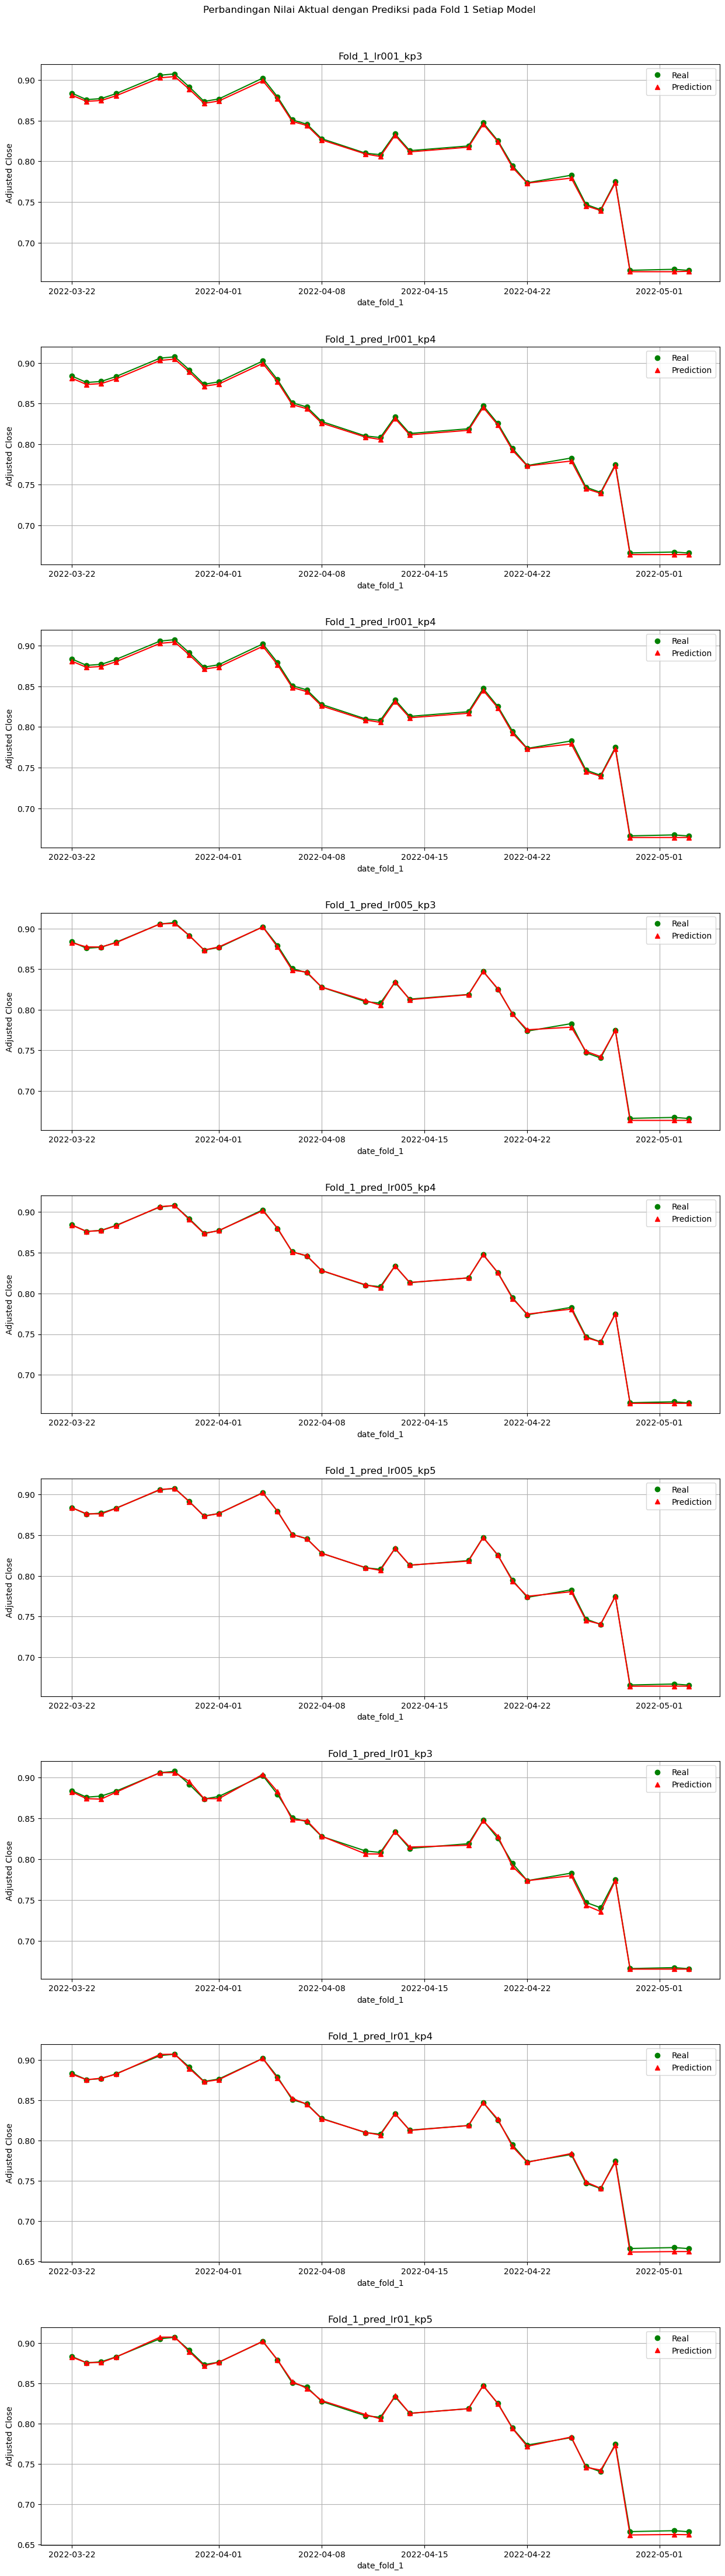

In [83]:
pred = ['pred_lr001_kp3', 'pred_lr001_kp4', 'pred_lr001_kp4',
        'pred_lr005_kp3', 'pred_lr005_kp4', 'pred_lr005_kp5',
        'pred_lr01_kp3', 'pred_lr01_kp4', 'pred_lr01_kp5']

titles = ['Fold_1_lr001_kp3', 'Fold_1_pred_lr001_kp4', 'Fold_1_pred_lr001_kp4',
        'Fold_1_pred_lr005_kp3', 'Fold_1_pred_lr005_kp4', 'Fold_1_pred_lr005_kp5',
        'Fold_1_pred_lr01_kp3', 'Fold_1_pred_lr01_kp4', 'Fold_1_pred_lr01_kp5']

fig, axs  = plt.subplots(9, 1, figsize=(15, 50))

for i, df in enumerate(pred):
    real_fold_1 = globals()[df]['real_fold_1']
    pred_fold_1 = globals()[df]['pred_fold_1']
    date_fold_1 = globals()[df]['date_fold_1']
    
    axs[i].plot(date_fold_1, real_fold_1, 'o', color='green', label='Real')
    axs[i].plot(date_fold_1, real_fold_1, color='green', linestyle='-')
    axs[i].plot(date_fold_1, pred_fold_1, '^', color='red', label='Prediction')
    axs[i].plot(date_fold_1, pred_fold_1, color='red', linestyle='-')
    axs[i].set_xlabel('date_fold_1')
    axs[i].set_ylabel('Adjusted Close')
    axs[i].set_title(titles[i])
    axs[i].grid()
    axs[i].legend()

plt.suptitle('Perbandingan Nilai Aktual dengan Prediksi pada Fold 1 Setiap Model')
plt.subplots_adjust(top=0.96, hspace=0.3)
plt.show()


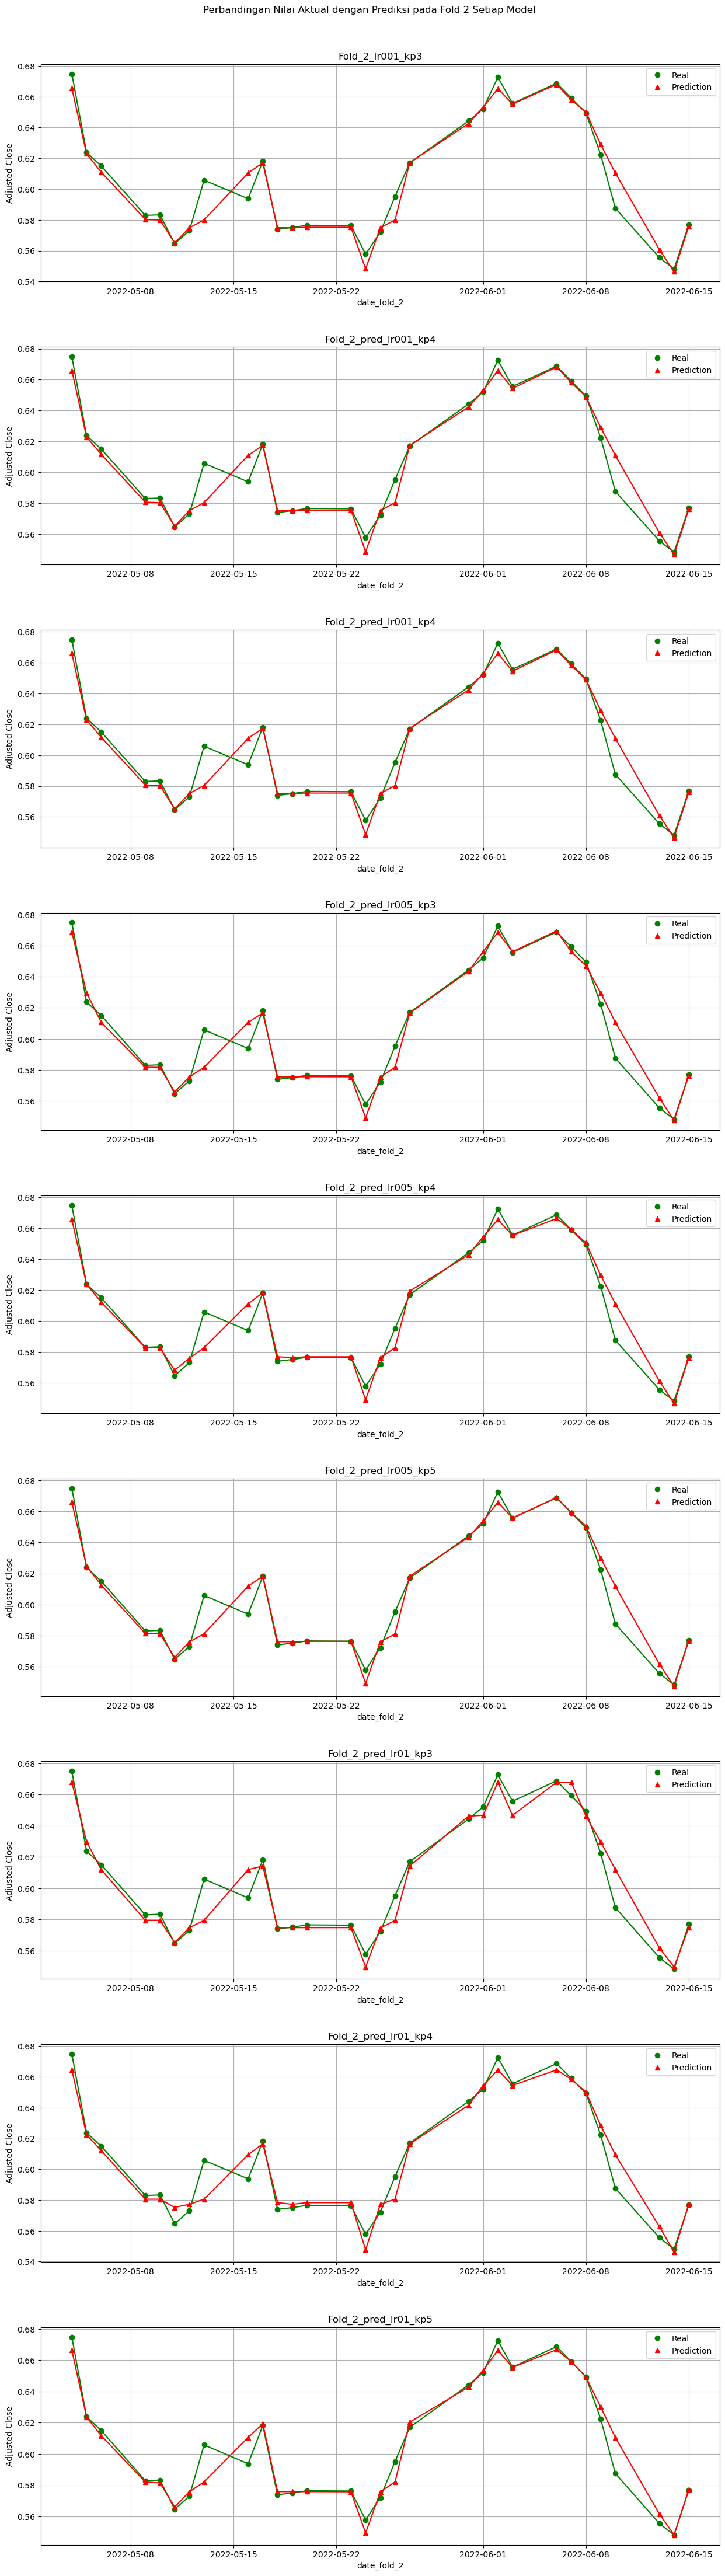

In [84]:
pred = ['pred_lr001_kp3', 'pred_lr001_kp4', 'pred_lr001_kp4',
        'pred_lr005_kp3', 'pred_lr005_kp4', 'pred_lr005_kp5',
        'pred_lr01_kp3', 'pred_lr01_kp4', 'pred_lr01_kp5']

titles = ['Fold_2_lr001_kp3', 'Fold_2_pred_lr001_kp4', 'Fold_2_pred_lr001_kp4',
        'Fold_2_pred_lr005_kp3', 'Fold_2_pred_lr005_kp4', 'Fold_2_pred_lr005_kp5',
        'Fold_2_pred_lr01_kp3', 'Fold_2_pred_lr01_kp4', 'Fold_2_pred_lr01_kp5']

fig, axs  = plt.subplots(9, 1, figsize=(15, 50))

for i, df in enumerate(pred):
    real_fold_1 = globals()[df]['real_fold_2']
    pred_fold_1 = globals()[df]['pred_fold_2']
    date_fold_1 = globals()[df]['date_fold_2']
    
    axs[i].plot(date_fold_1, real_fold_1, 'o', color='green', label='Real')
    axs[i].plot(date_fold_1, real_fold_1, color='green', linestyle='-')
    axs[i].plot(date_fold_1, pred_fold_1, '^', color='red', label='Prediction')
    axs[i].plot(date_fold_1, pred_fold_1, color='red', linestyle='-')
    axs[i].set_xlabel('date_fold_2')
    axs[i].set_ylabel('Adjusted Close')
    axs[i].set_title(titles[i])
    axs[i].grid()
    axs[i].legend()

plt.suptitle('Perbandingan Nilai Aktual dengan Prediksi pada Fold 2 Setiap Model')
plt.subplots_adjust(top=0.96, hspace=0.3)
plt.show()


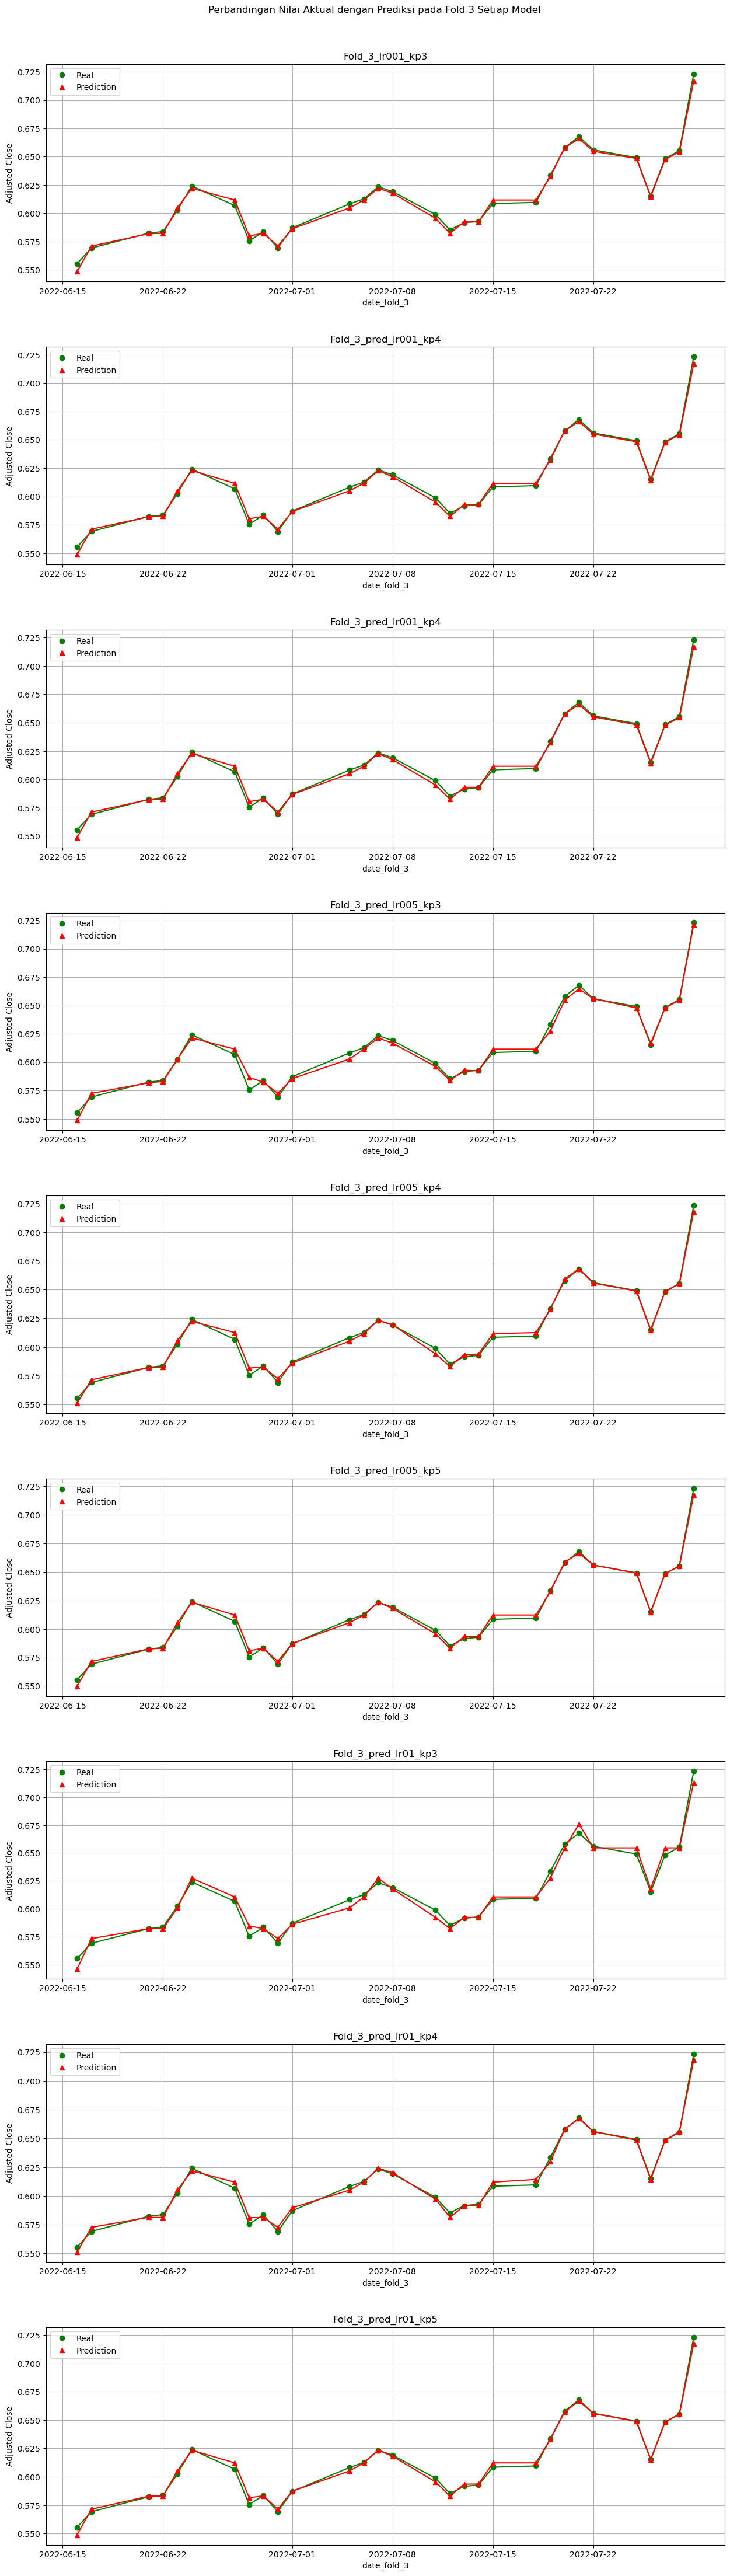

In [85]:
pred = ['pred_lr001_kp3', 'pred_lr001_kp4', 'pred_lr001_kp4',
        'pred_lr005_kp3', 'pred_lr005_kp4', 'pred_lr005_kp5',
        'pred_lr01_kp3', 'pred_lr01_kp4', 'pred_lr01_kp5']

titles = ['Fold_3_lr001_kp3', 'Fold_3_pred_lr001_kp4', 'Fold_3_pred_lr001_kp4',
        'Fold_3_pred_lr005_kp3', 'Fold_3_pred_lr005_kp4', 'Fold_3_pred_lr005_kp5',
        'Fold_3_pred_lr01_kp3', 'Fold_3_pred_lr01_kp4', 'Fold_3_pred_lr01_kp5']

fig, axs  = plt.subplots(9, 1, figsize=(15, 50))

for i, df in enumerate(pred):
    real_fold_1 = globals()[df]['real_fold_3']
    pred_fold_1 = globals()[df]['pred_fold_3']
    date_fold_1 = globals()[df]['date_fold_3']
    
    axs[i].plot(date_fold_1, real_fold_1, 'o', color='green', label='Real')
    axs[i].plot(date_fold_1, real_fold_1, color='green', linestyle='-')
    axs[i].plot(date_fold_1, pred_fold_1, '^', color='red', label='Prediction')
    axs[i].plot(date_fold_1, pred_fold_1, color='red', linestyle='-')
    axs[i].set_xlabel('date_fold_3')
    axs[i].set_ylabel('Adjusted Close')
    axs[i].set_title(titles[i])
    axs[i].grid()
    axs[i].legend()

plt.suptitle('Perbandingan Nilai Aktual dengan Prediksi pada Fold 3 Setiap Model')
plt.subplots_adjust(top=0.96, hspace=0.3)
plt.show()


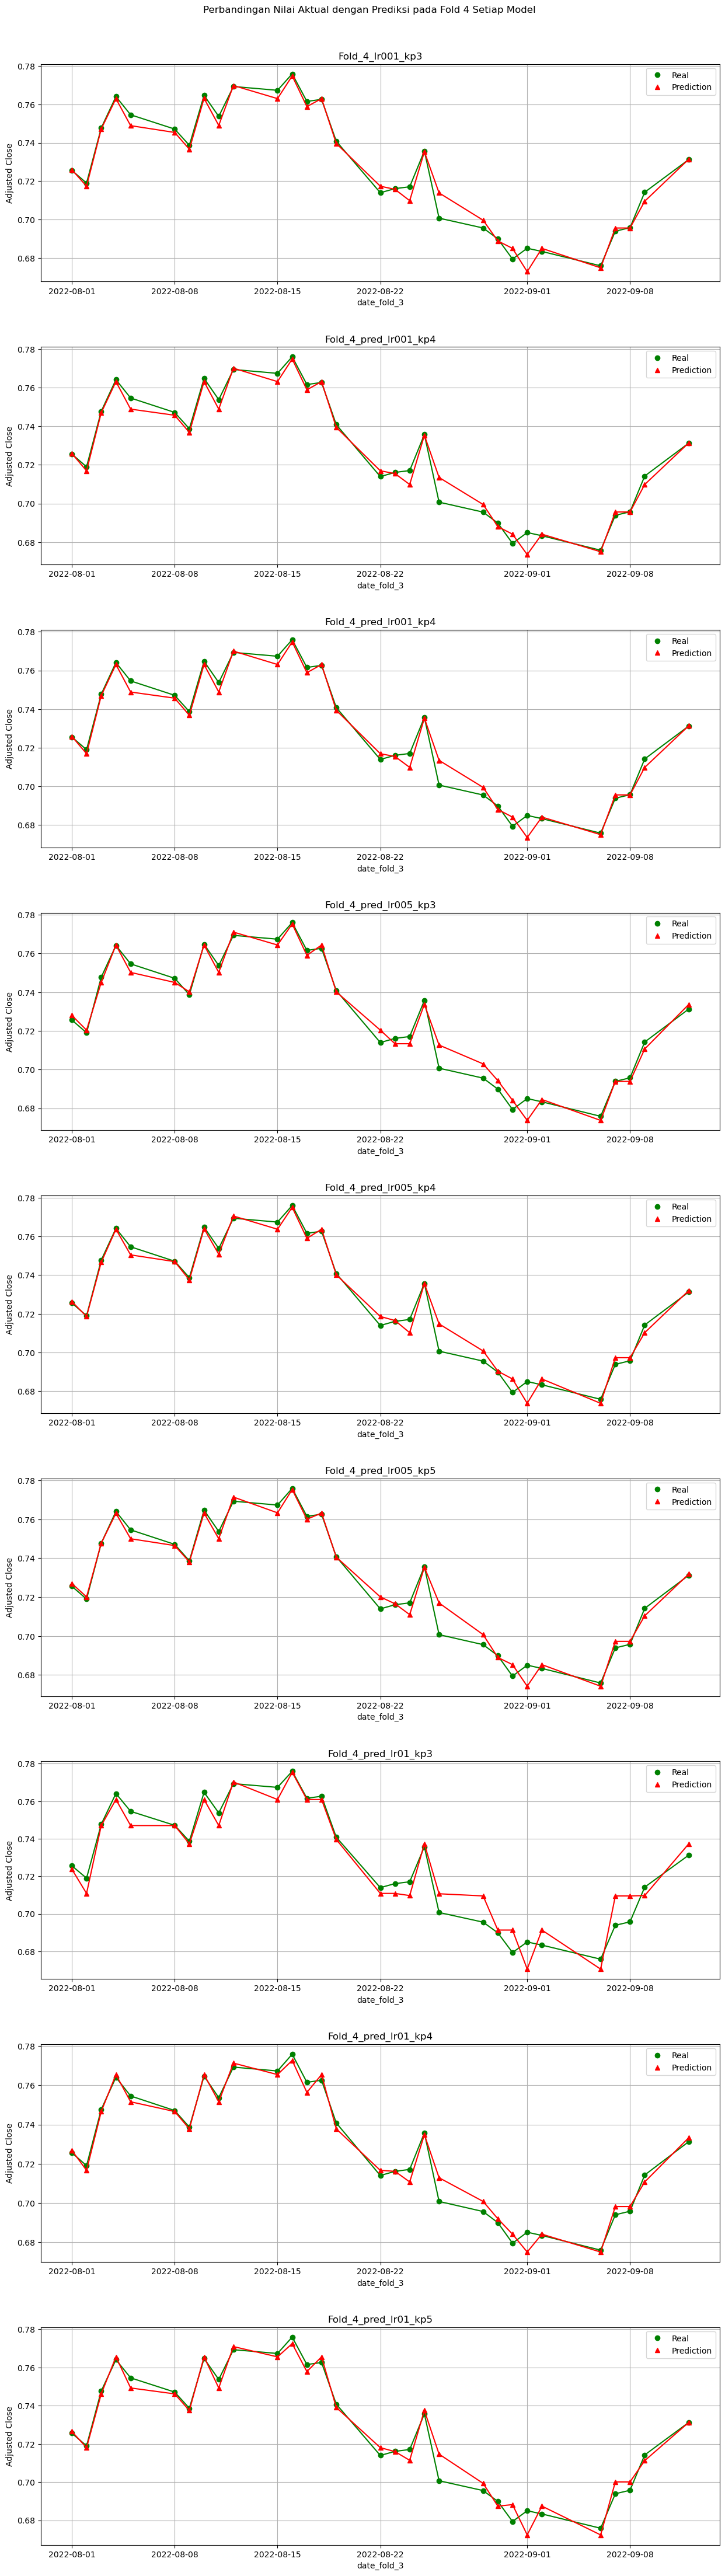

In [86]:
pred = ['pred_lr001_kp3', 'pred_lr001_kp4', 'pred_lr001_kp4',
        'pred_lr005_kp3', 'pred_lr005_kp4', 'pred_lr005_kp5',
        'pred_lr01_kp3', 'pred_lr01_kp4', 'pred_lr01_kp5']

titles = ['Fold_4_lr001_kp3', 'Fold_4_pred_lr001_kp4', 'Fold_4_pred_lr001_kp4',
        'Fold_4_pred_lr005_kp3', 'Fold_4_pred_lr005_kp4', 'Fold_4_pred_lr005_kp5',
        'Fold_4_pred_lr01_kp3', 'Fold_4_pred_lr01_kp4', 'Fold_4_pred_lr01_kp5']

fig, axs  = plt.subplots(9, 1, figsize=(15, 50))

for i, df in enumerate(pred):
    real_fold_1 = globals()[df]['real_fold_4']
    pred_fold_1 = globals()[df]['pred_fold_4']
    date_fold_1 = globals()[df]['date_fold_4']
    
    axs[i].plot(date_fold_1, real_fold_1, 'o', color='green', label='Real')
    axs[i].plot(date_fold_1, real_fold_1, color='green', linestyle='-')
    axs[i].plot(date_fold_1, pred_fold_1, '^', color='red', label='Prediction')
    axs[i].plot(date_fold_1, pred_fold_1, color='red', linestyle='-')
    axs[i].set_xlabel('date_fold_3')
    axs[i].set_ylabel('Adjusted Close')
    axs[i].set_title(titles[i])
    axs[i].grid()
    axs[i].legend()

plt.suptitle('Perbandingan Nilai Aktual dengan Prediksi pada Fold 4 Setiap Model')
plt.subplots_adjust(top=0.96, hspace=0.3)
plt.show()


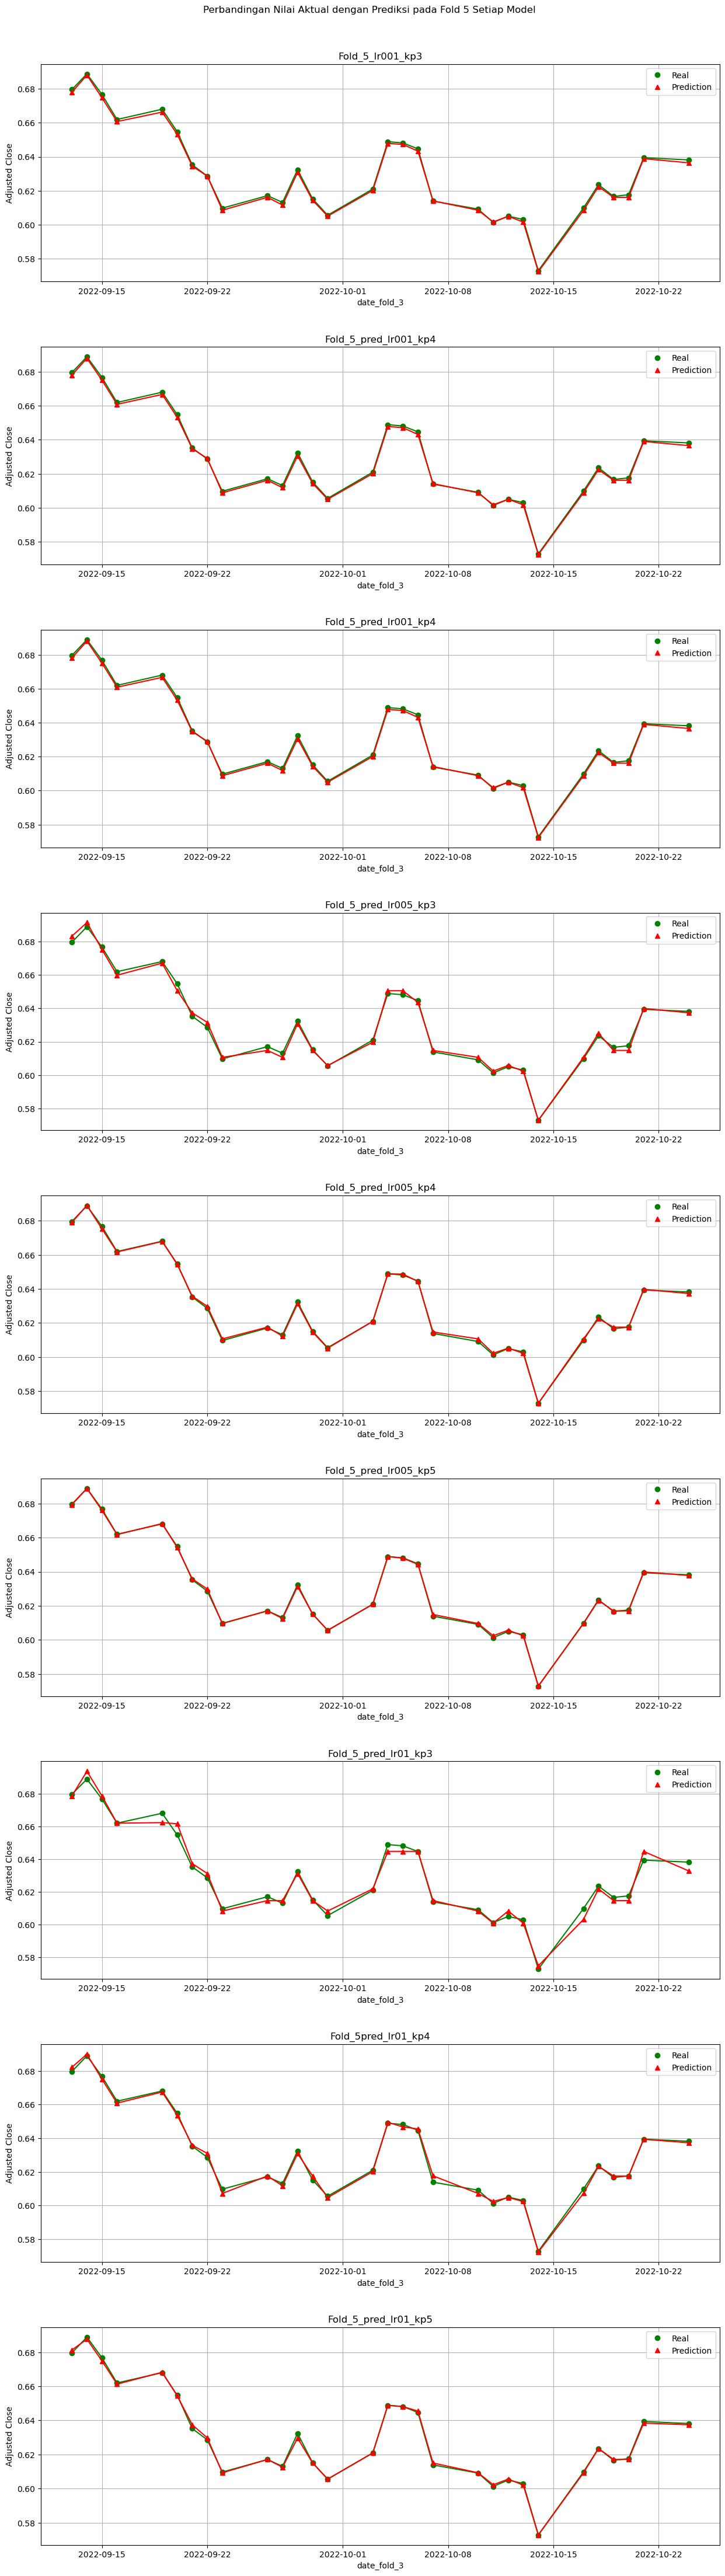

In [87]:
pred = ['pred_lr001_kp3', 'pred_lr001_kp4', 'pred_lr001_kp4',
        'pred_lr005_kp3', 'pred_lr005_kp4', 'pred_lr005_kp5',
        'pred_lr01_kp3', 'pred_lr01_kp4', 'pred_lr01_kp5']

titles = ['Fold_5_lr001_kp3', 'Fold_5_pred_lr001_kp4', 'Fold_5_pred_lr001_kp4',
        'Fold_5_pred_lr005_kp3', 'Fold_5_pred_lr005_kp4', 'Fold_5_pred_lr005_kp5',
        'Fold_5_pred_lr01_kp3', 'Fold_5pred_lr01_kp4', 'Fold_5_pred_lr01_kp5']

fig, axs  = plt.subplots(9, 1, figsize=(15, 50))

for i, df in enumerate(pred):
    real_fold_1 = globals()[df]['real_fold_5']
    pred_fold_1 = globals()[df]['pred_fold_5']
    date_fold_1 = globals()[df]['date_fold_5']
    
    axs[i].plot(date_fold_1, real_fold_1, 'o', color='green', label='Real')
    axs[i].plot(date_fold_1, real_fold_1, color='green', linestyle='-')
    axs[i].plot(date_fold_1, pred_fold_1, '^', color='red', label='Prediction')
    axs[i].plot(date_fold_1, pred_fold_1, color='red', linestyle='-')
    axs[i].set_xlabel('date_fold_3')
    axs[i].set_ylabel('Adjusted Close')
    axs[i].set_title(titles[i])
    axs[i].grid()
    axs[i].legend()

plt.suptitle('Perbandingan Nilai Aktual dengan Prediksi pada Fold 5 Setiap Model')
plt.subplots_adjust(top=0.96, hspace=0.3)
plt.show()


#### Visualisasi nilai Importance

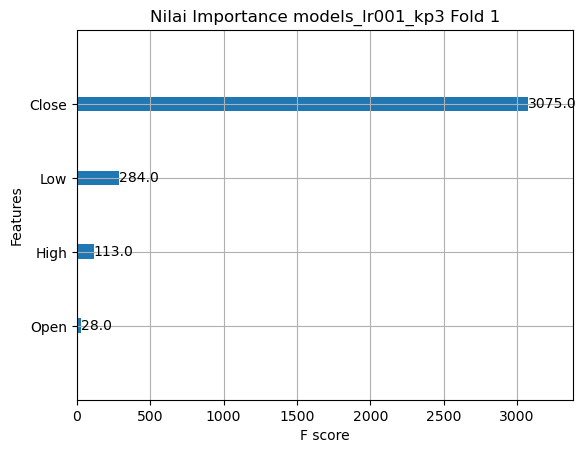

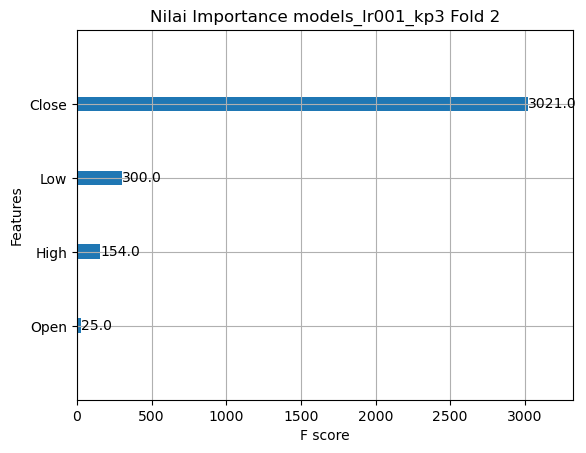

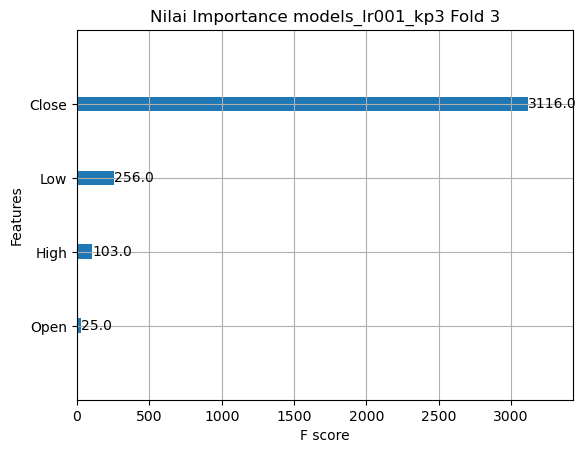

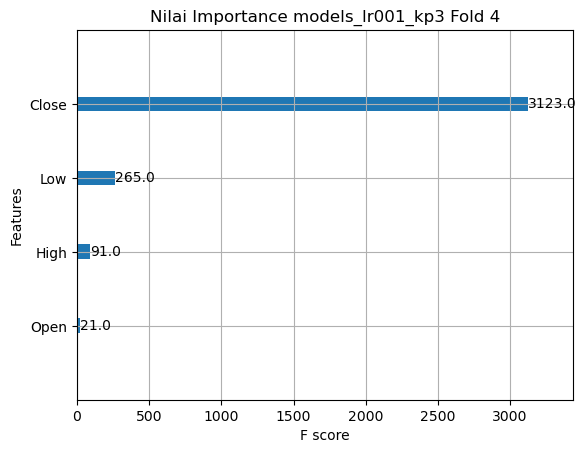

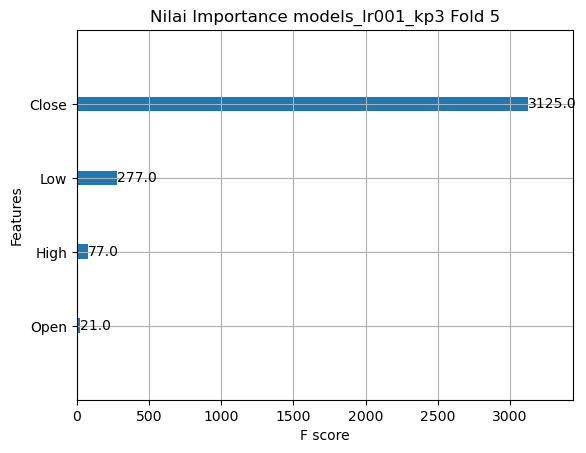

In [88]:
for i, model in enumerate(models_lr001_kp3):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr001_kp3 Fold {i+1}")

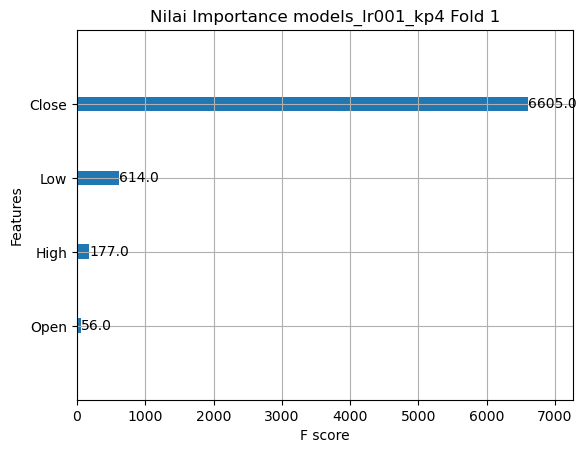

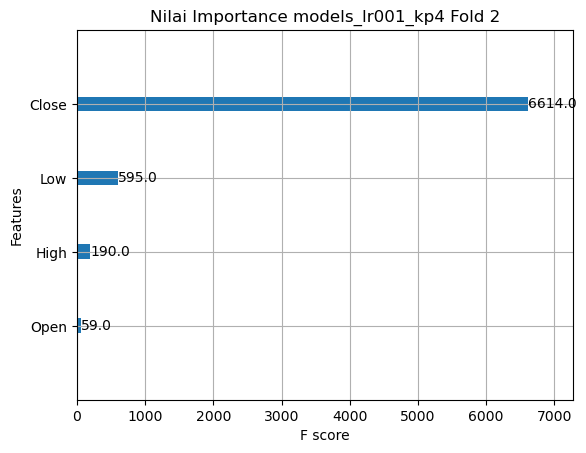

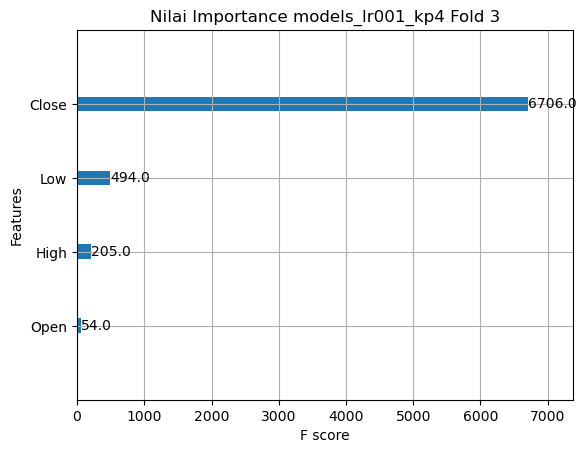

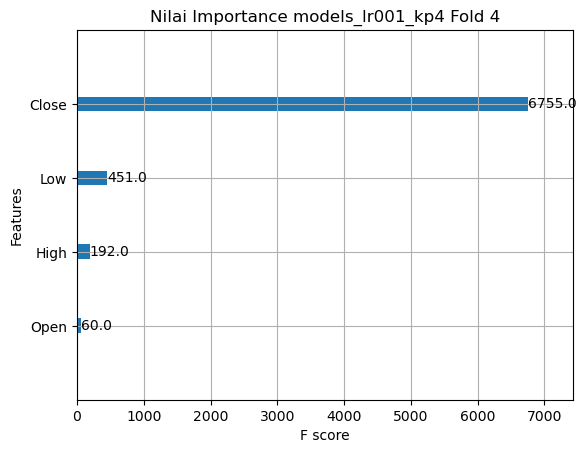

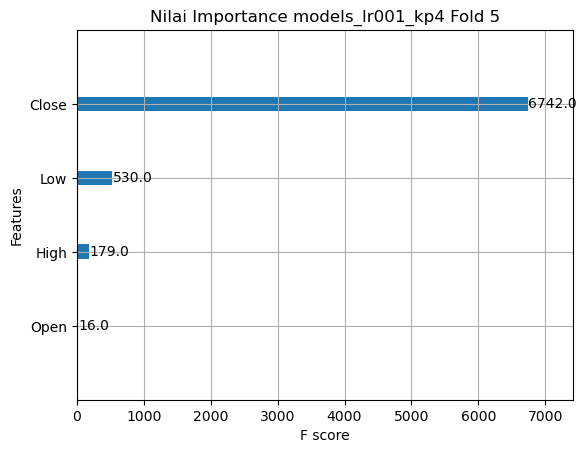

In [89]:
for i, model in enumerate(models_lr001_kp4):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr001_kp4 Fold {i+1}")

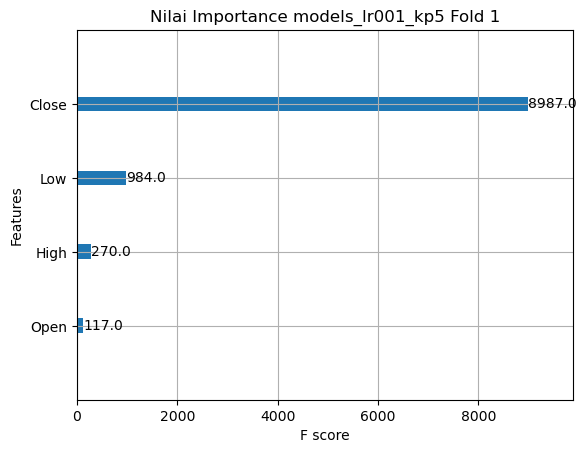

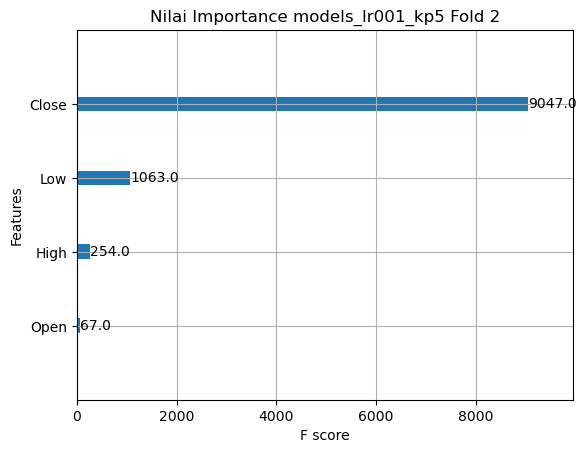

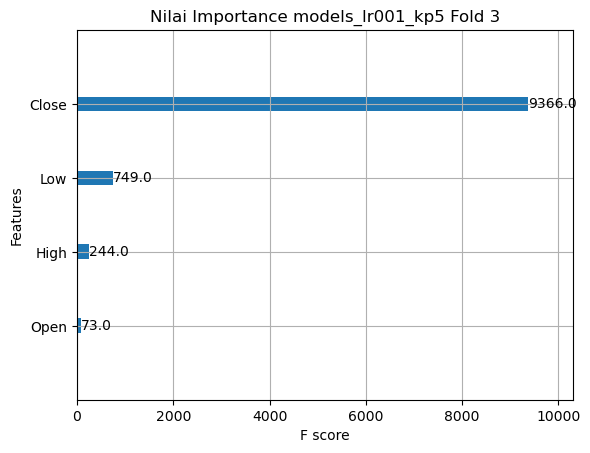

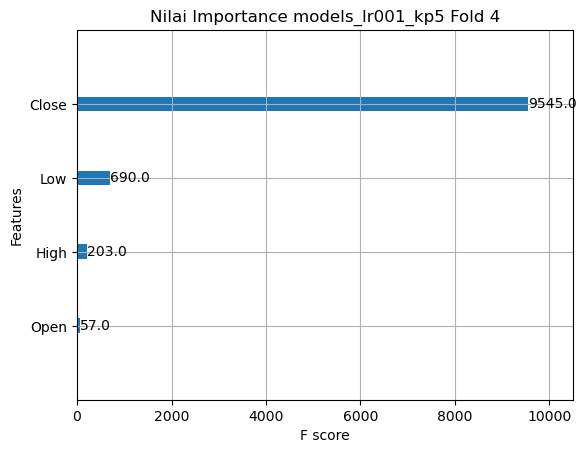

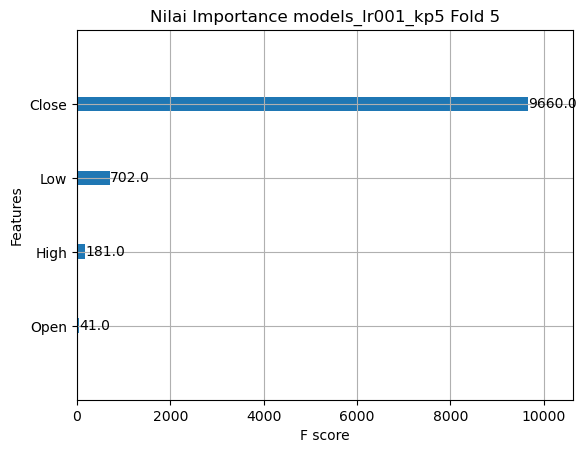

In [90]:
for i, model in enumerate(models_lr001_kp5):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr001_kp5 Fold {i+1}")

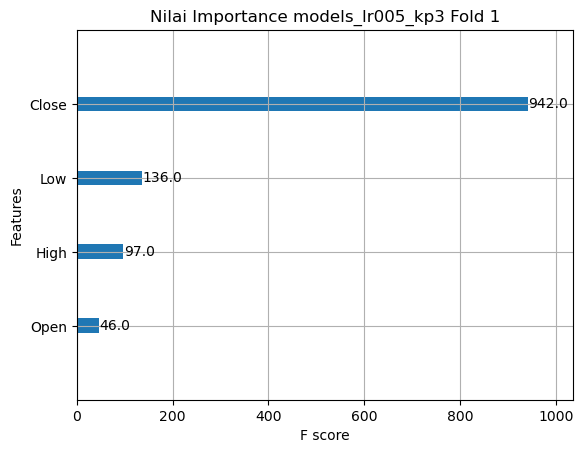

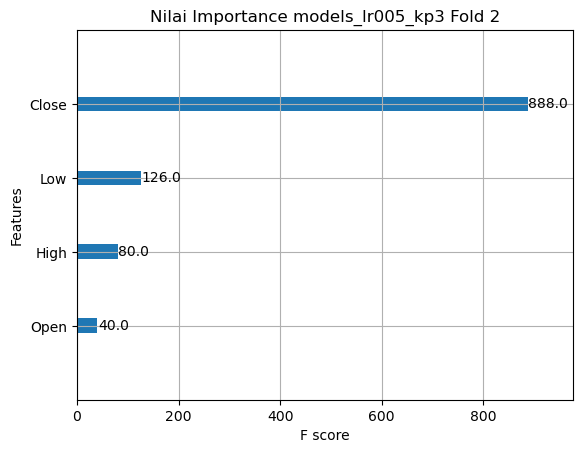

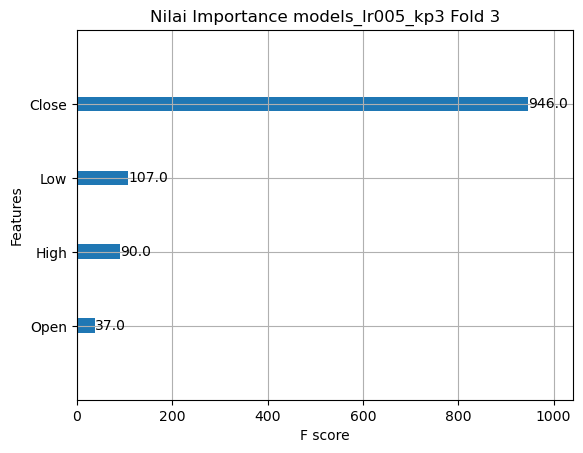

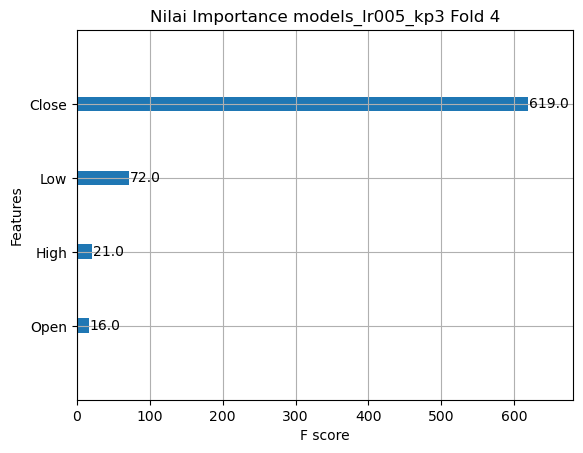

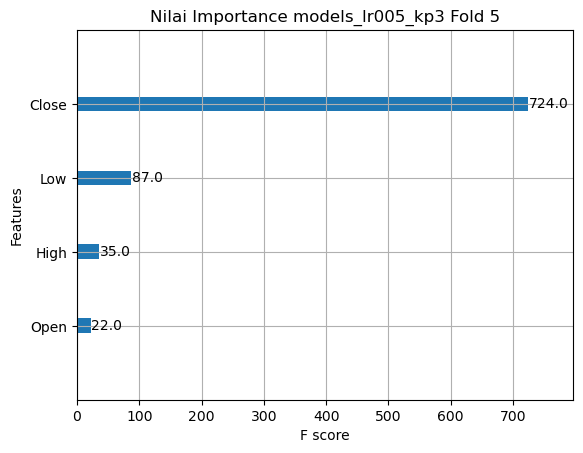

In [91]:
for i, model in enumerate(models_lr005_kp3):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr005_kp3 Fold {i+1}")

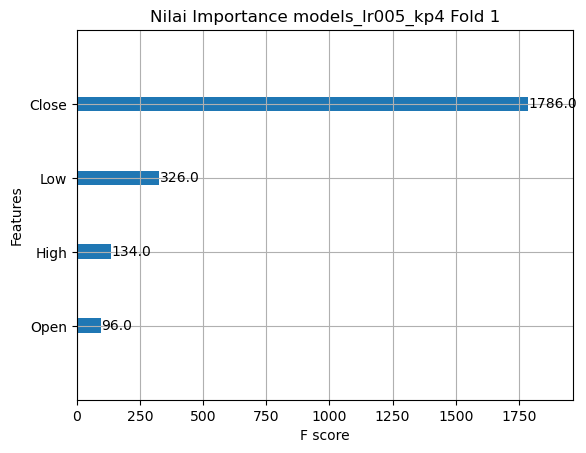

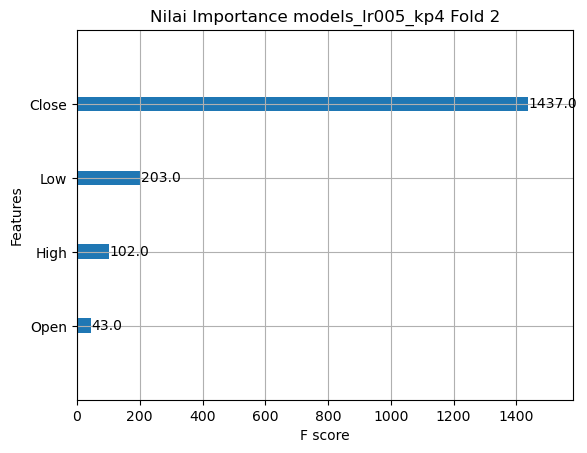

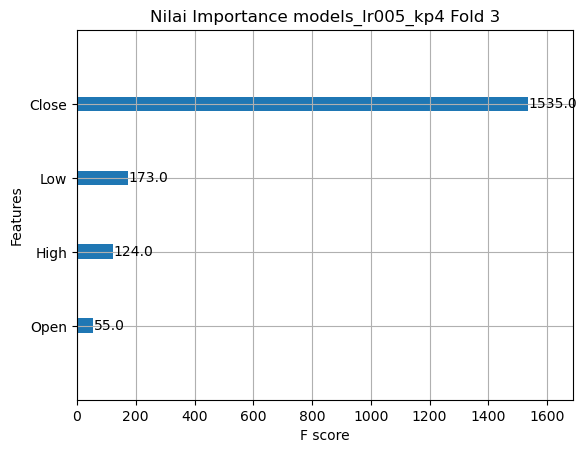

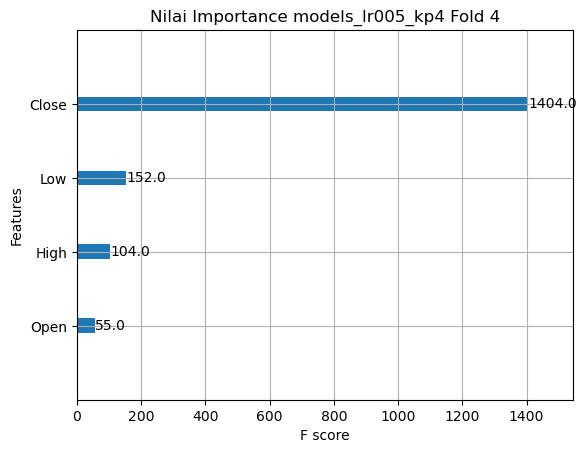

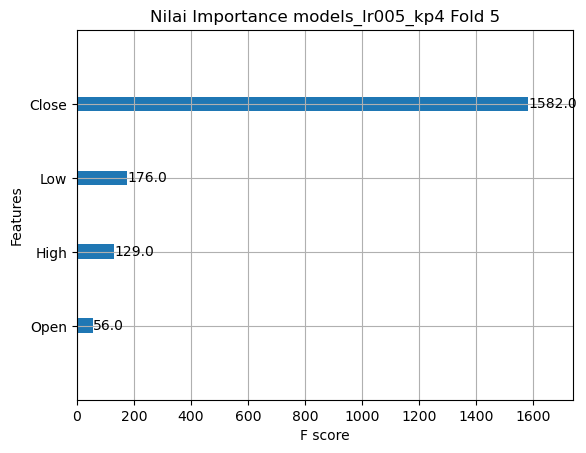

In [92]:
for i, model in enumerate(models_lr005_kp4):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr005_kp4 Fold {i+1}")

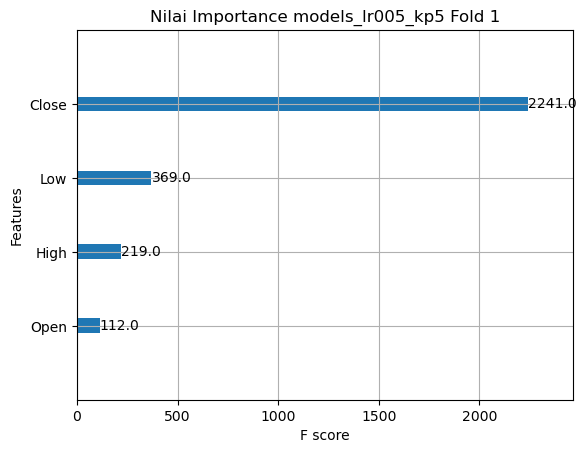

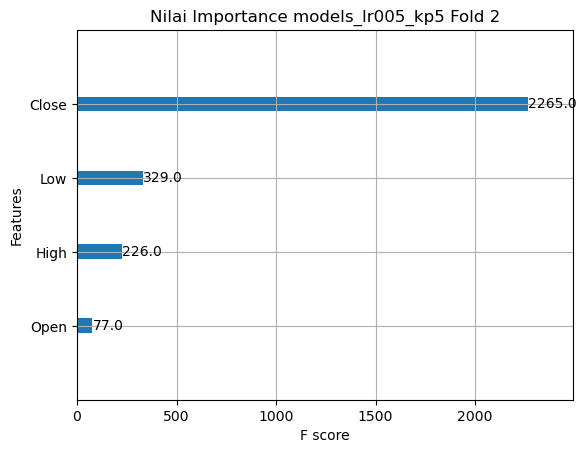

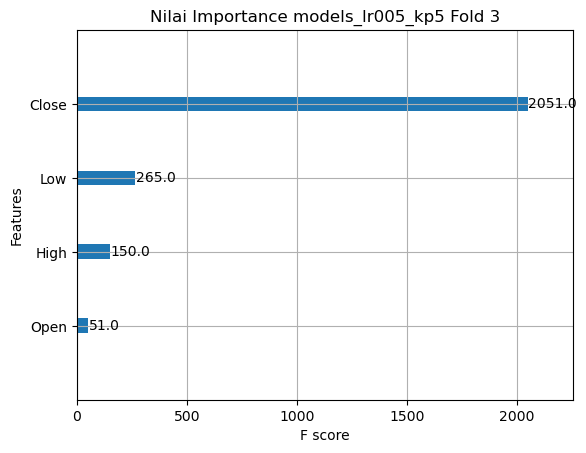

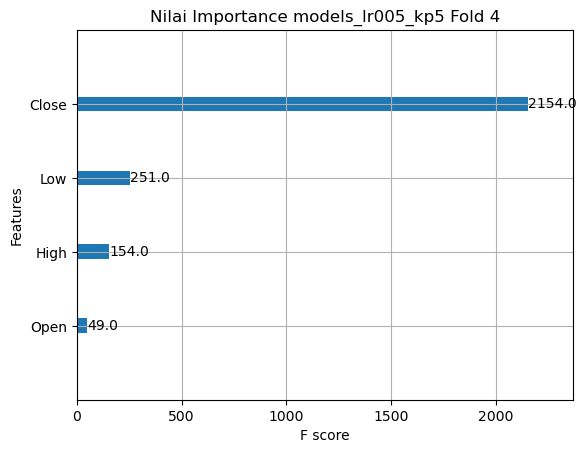

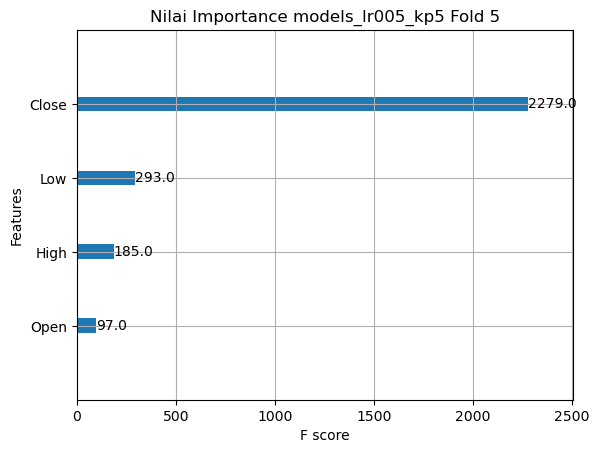

In [93]:
for i, model in enumerate(models_lr005_kp5):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr005_kp5 Fold {i+1}")

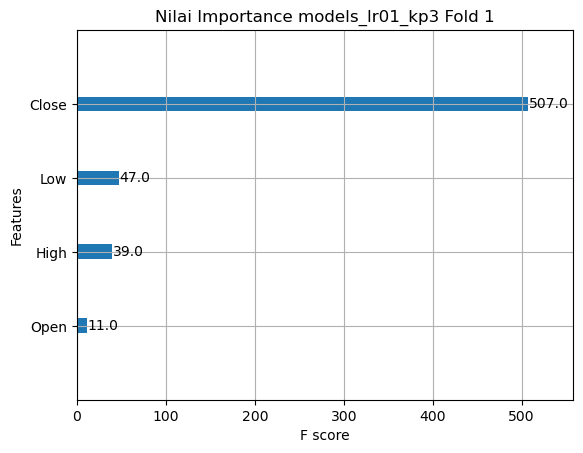

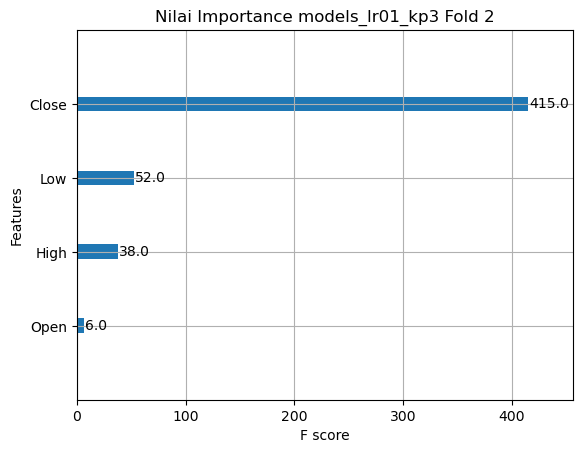

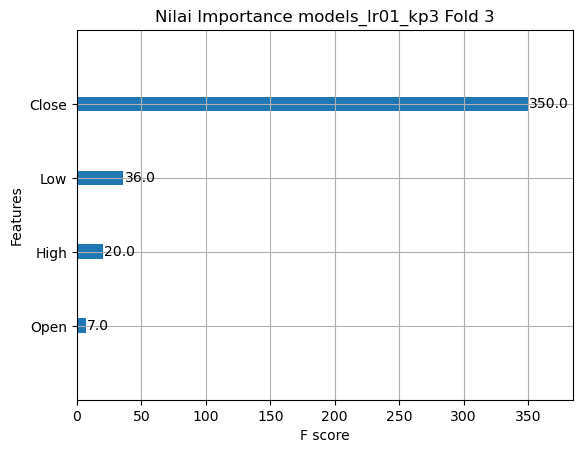

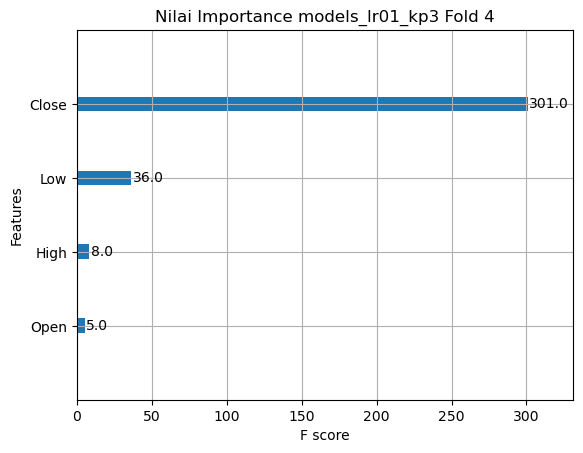

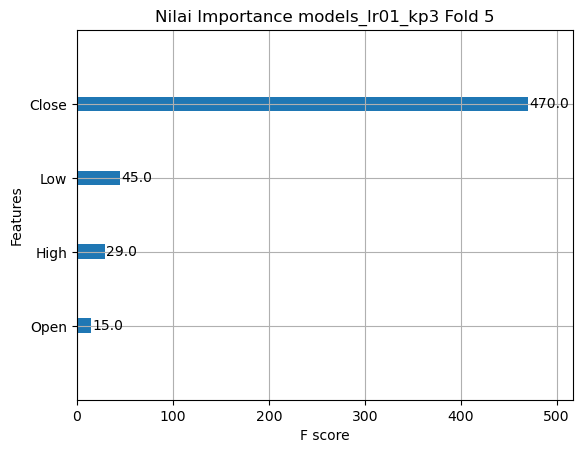

In [94]:
for i, model in enumerate(models_lr01_kp3):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr01_kp3 Fold {i+1}")

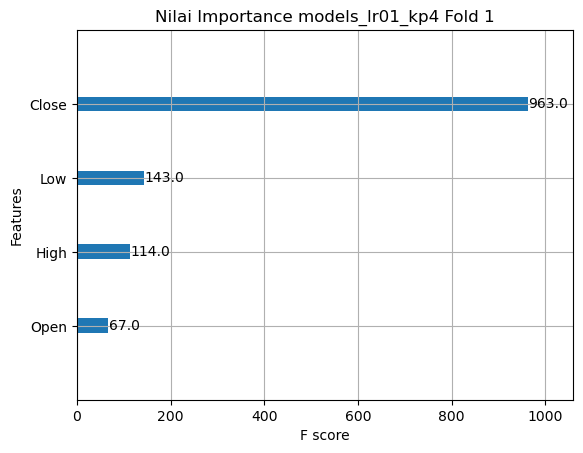

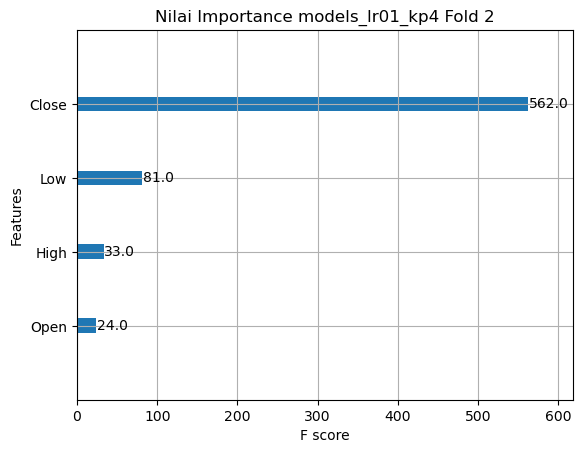

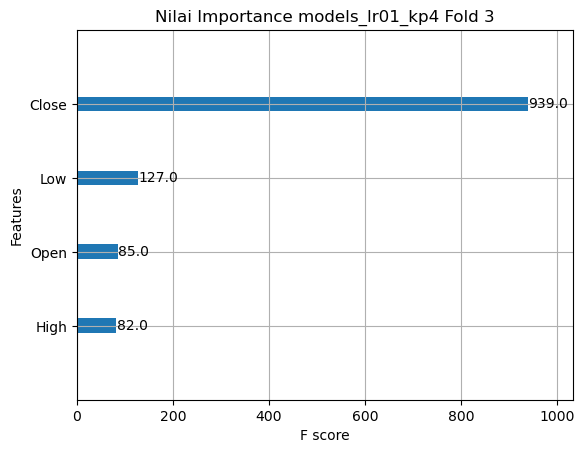

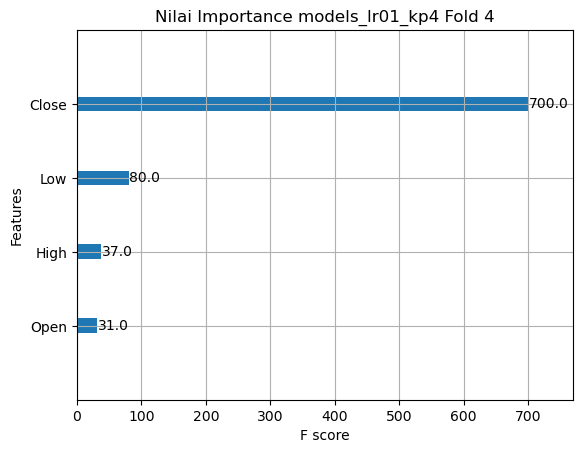

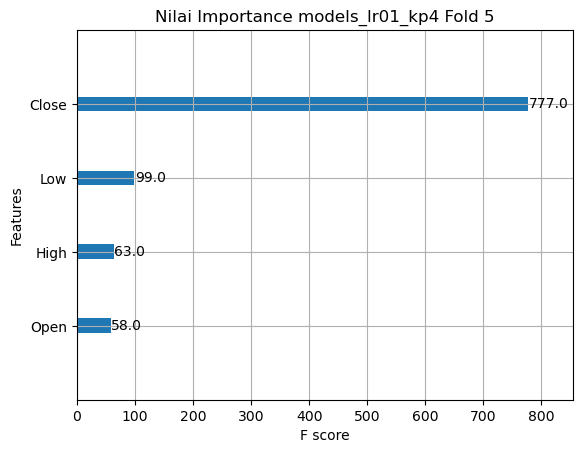

In [95]:
for i, model in enumerate(models_lr01_kp4):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr01_kp4 Fold {i+1}")

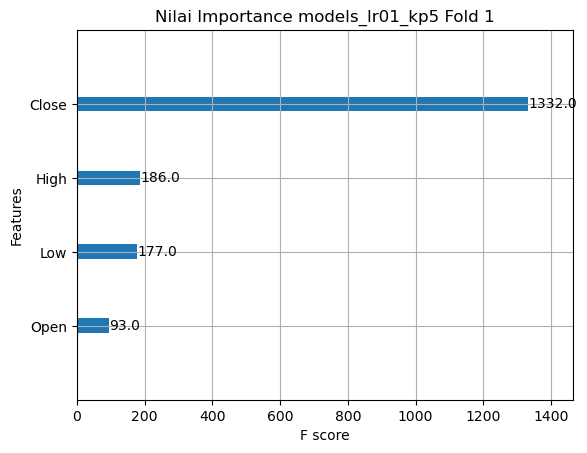

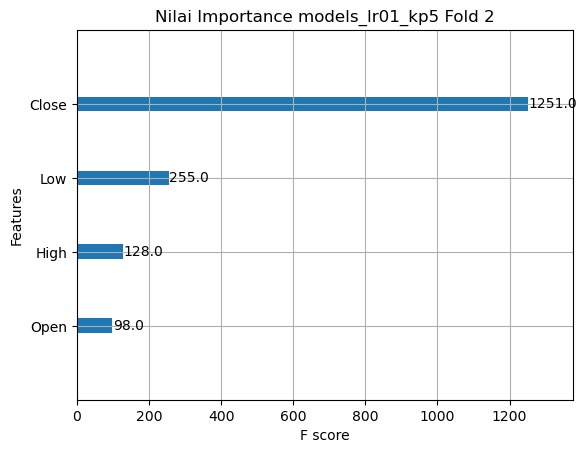

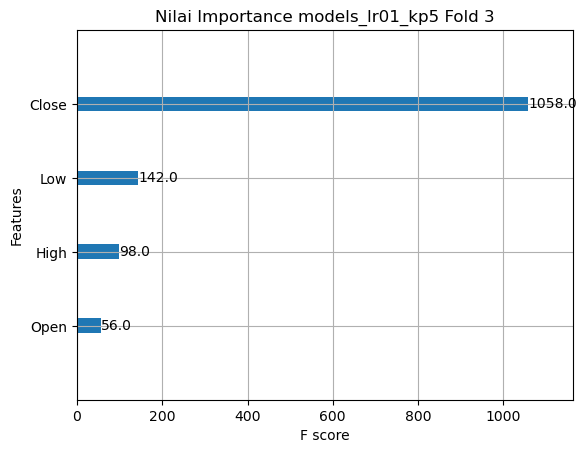

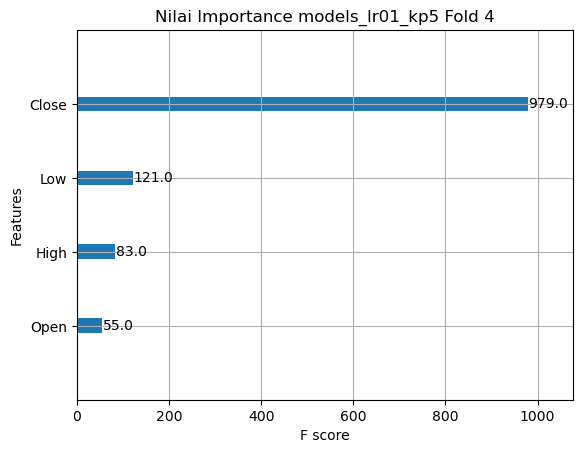

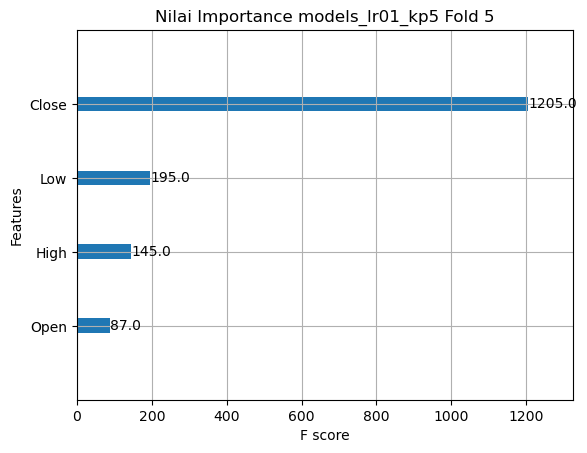

In [96]:
for i, model in enumerate(models_lr01_kp5):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr01_kp5 Fold {i+1}")